In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
from PIL import Image
from time import time
import math

In [10]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [13]:
#!unzip -u "/content/drive/MyDrive/sisi/out_color_images.zip" -d "/content/drive/MyDrive/sisi"

In [11]:
data_dir_bw = "/content/drive/MyDrive/sisi/out_bw_images"
data_dir_col = "/content/drive/MyDrive/sisi/out_color_images"

In [12]:
assert len(os.listdir(data_dir_col)) == 11640
assert len(os.listdir(data_dir_bw)) == 11640

In [14]:
SIZE = 100 # 100x100 dimensions

In [15]:
def load_images(data_dir, force_rgb=False):
    images = []
    labels = []
    total = len(os.listdir(data_dir))
    for i, image_name in enumerate(os.listdir(data_dir)):
        if (i % (total//5) == 0):
            print(f'INFO: Loading image {i+1}/{total}')
        path = os.path.join(data_dir, image_name)
        im = Image.open(path)
        if force_rgb:
            im = im.convert('RGB')
        images.append(np.asarray(im))
        labels.append(image_name.split("-")[1].rsplit(".", 1)[0])

    # Map characters to integers
    labels_mapping = {i: l for i, l in enumerate(sorted(set(labels)))}
    labels_mapping_rev = {l: i for i, l in labels_mapping.items()}

    labels = [labels_mapping_rev[l] for l in labels]

    images = np.array(images)
    labels = np.array(labels)
    return images, labels, labels_mapping

In [16]:
def plot_data(images, labels, labels_mapping, cmap=None, size_y=5, size_x=5):
    plt.figure(figsize=(10,10))
    for i, image in enumerate(images[: size_x * size_y]):
        plt.subplot(size_x, size_y,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image, cmap=cmap)
        plt.xlabel(labels_mapping[labels[i]])
    plt.show()

In [17]:
data_col = load_images(data_dir_col)
data_bw = load_images(data_dir_bw)
data_bw_3_channels = load_images(data_dir_bw, force_rgb=True)  # for transfer learning

INFO: Loading image 1/11640
INFO: Loading image 2329/11640
INFO: Loading image 4657/11640
INFO: Loading image 6985/11640
INFO: Loading image 9313/11640
INFO: Loading image 1/11640
INFO: Loading image 2329/11640
INFO: Loading image 4657/11640
INFO: Loading image 6985/11640
INFO: Loading image 9313/11640
INFO: Loading image 1/11640
INFO: Loading image 2329/11640
INFO: Loading image 4657/11640
INFO: Loading image 6985/11640
INFO: Loading image 9313/11640


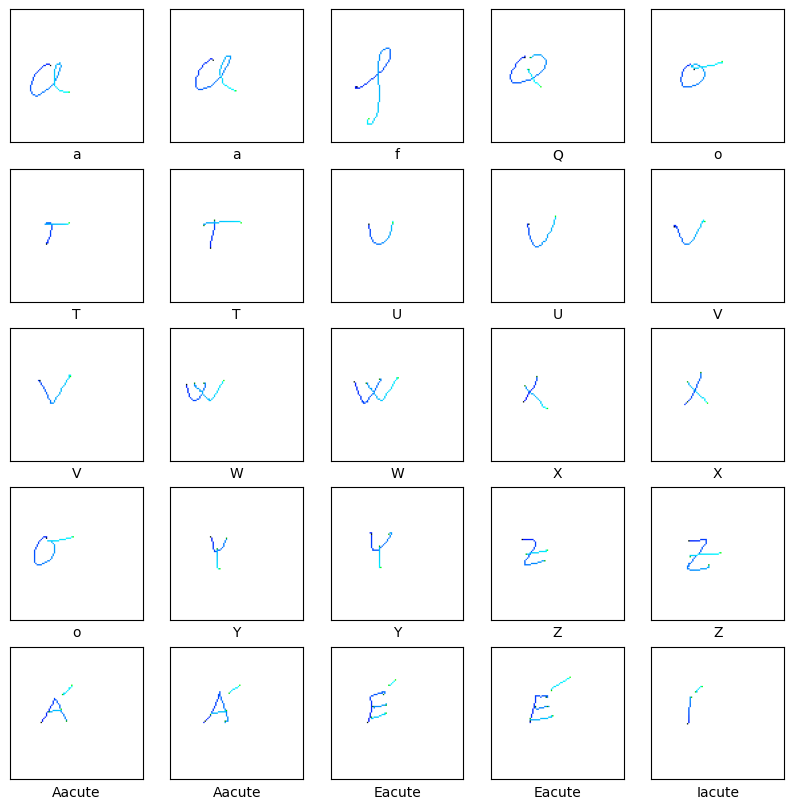

In [18]:
plot_data(*data_col)

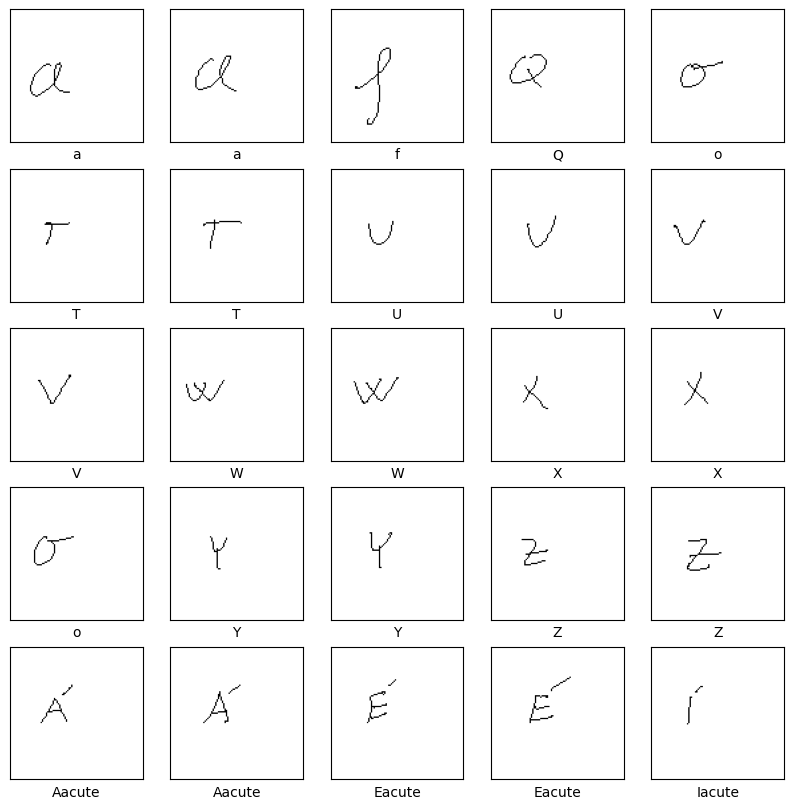

In [ ]:
plot_data(*data_bw, cmap='gray')

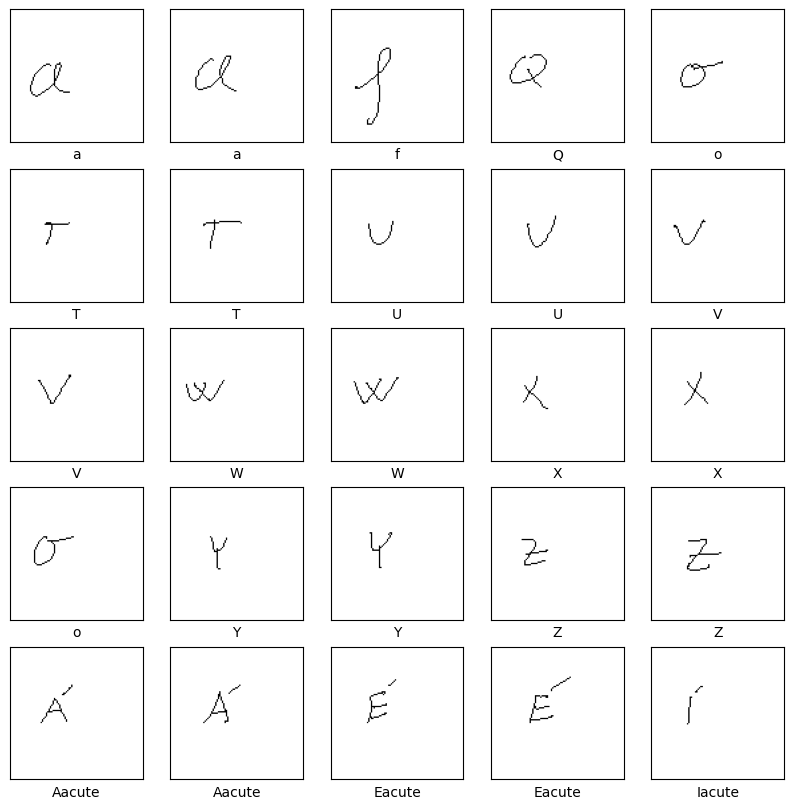

In [ ]:
plot_data(*data_bw_3_channels)

In [19]:
class PreparedData:
    def __init__(self, train_images, train_labels, test_images, test_labels, labels_len):
        self.train_images = np.array(train_images)
        self.train_labels = np.array(train_labels)
        self.test_images= np.array(test_images)
        self.test_labels = np.array(test_labels)
        self.labels_len = labels_len
        train_labels_oh = tf.one_hot(self.train_labels, labels_len)
        self.train_labels_oh = train_labels_oh.reshape(train_labels_oh.shape[0], labels_len)
        test_labels_oh = tf.one_hot(self.test_labels, labels_len)
        self.test_labels_oh = test_labels_oh.reshape(test_labels_oh.shape[0], labels_len)

In [20]:
def prepare_data(images, labels, labels_mapping, idx=100):
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []
    for l in labels_mapping.keys():
        label_images = images[labels == l]
        train_images.extend(label_images[:idx])
        train_labels.extend([l]*idx)
        test_images.extend(label_images[idx:])
        test_labels.extend([l]*(len(label_images) - idx))
    return PreparedData(train_images, train_labels, test_images, test_labels, len(labels_mapping))

In [21]:
d_col = prepare_data(*data_col)
d_bw = prepare_data(*data_bw)
d_bw_3= prepare_data(*data_bw_3_channels)

In [ ]:
# d_col.train_images.shape, d_col.train_labels.shape, d_col.test_images.shape, d_col.test_labels.shape

In [26]:
def plot_subplot(hist_bw, hist_col, title, metric):
    epochs = [i for i in range(1, len(hist_bw['loss']) + 1)]
    plt.xlim([1, len(epochs)])
    plt.ylim([0, 0.6 if metric == 'loss' else 1])
    plt.xlabel("Numer epoki")
    polish_name = 'F. kosztu ' if metric == 'loss' else 'Dokładność '
    plt.ylabel("Wartość " + ("funkcji kosztu" if metric == "loss" else "dokładności"))
    plt.plot(epochs, hist_bw[metric], label=polish_name + "dla zb. treningowego - czarno-białe obrazy", c='purple')
    plt.plot(epochs, hist_bw['val_' + metric], label=polish_name + "dla zb. walidacyjnego - czarno-białe obrazy", c='violet')
    plt.plot(epochs, hist_col[metric], label=polish_name + "dla zb.treningowego - kolorowe obrazy", c='navy')
    plt.plot(epochs, hist_col['val_' + metric], label=polish_name + "dla zb. treningowego - kolorowe obrazy", c='royalblue')
    plt.title(title + " - " + ("Funkcja kosztu" if metric == 'loss' else "Dokładność"))
    plt.legend(loc='upper right', bbox_to_anchor=(0.5, -0.15))

def plot_params(hist_bw, hist_col, title):
    plt.figure(figsize=(10, 10), dpi=100)

    plt.subplot(2, 1, 1)
    plot_subplot(hist_bw, hist_col, title, 'accuracy')
    
    plt.subplot(2, 1, 2)
    plot_subplot(hist_bw, hist_col, title, 'loss')

    plt.subplots_adjust(hspace=0.6)
    plt.show()

In [23]:
def run_model(model, data, epochs=150):
    start_time = time()
    hist = model.fit(data.train_images, data.train_labels_oh, batch_size=64, epochs=epochs, validation_data=(data.test_images, data.test_labels_oh))
    elapsed_time = time() - start_time
    print("Elapsed time [s]:", elapsed_time)
    return hist.history

In [24]:
def add_conv_block(model, filters, activation=tf.keras.activations.sigmoid, dropout=0):
    model.add(tf.keras.layers.Conv2D(filters, (3, 3), padding='SAME', activation=activation))
    model.add(tf.keras.layers.Conv2D(filters, (3, 3), padding='SAME', activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='SAME'))
    if dropout > 0:
        model.add(tf.keras.layers.Dropout(dropout))

In [25]:
# backup if we wish to change charts

def dump_res(res_bw, res_c):
    for h in [res_bw, res_c]:
        print(max(h['val_accuracy']), h['val_accuracy'])
        print(max(h['accuracy']), h['accuracy'])
        print(min(h['val_loss']), h['val_loss'])
        print(min(h['loss']), h['loss'])

# Eksperymenty


In [ ]:
def get_basic_model(labels_len, channels_num=3):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(100, 100, channels_num)))
    model.add(tf.keras.layers.Rescaling(scale=1./255))
    add_conv_block(model, 20, activation=tf.keras.activations.relu, dropout=0.1)
    model.add(tf.keras.layers.BatchNormalization())
    add_conv_block(model, 40, activation=tf.keras.activations.relu, dropout=0.2)
    model.add(tf.keras.layers.BatchNormalization())
    add_conv_block(model, 80, activation=tf.keras.activations.relu, dropout=0.3)
    model.add(tf.keras.layers.BatchNormalization())
    add_conv_block(model, 160, activation=tf.keras.activations.relu, dropout=0.4)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(labels_len, activation=tf.keras.activations.softmax))
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])
    return model

In [ ]:
res_c = run_model(get_basic_model(d_col.labels_len), d_col)
res_bw = run_model(get_basic_model(d_bw.labels_len, 1), d_bw)

Epoch 1/150
152/152 [==============================] - 11s 60ms/step - loss: 5.1039 - accuracy: 0.0231 - val_loss: 5.3478 - val_accuracy: 0.0103
Epoch 2/150
152/152 [==============================] - 8s 55ms/step - loss: 3.9604 - accuracy: 0.1000 - val_loss: 7.0901 - val_accuracy: 0.0103
Epoch 3/150
152/152 [==============================] - 9s 58ms/step - loss: 3.3004 - accuracy: 0.1759 - val_loss: 5.9831 - val_accuracy: 0.0108
Epoch 4/150
152/152 [==============================] - 9s 58ms/step - loss: 2.7034 - accuracy: 0.2849 - val_loss: 3.1819 - val_accuracy: 0.1943
Epoch 5/150
152/152 [==============================] - 10s 64ms/step - loss: 2.1454 - accuracy: 0.4115 - val_loss: 2.0413 - val_accuracy: 0.4376
Epoch 6/150
152/152 [==============================] - 9s 59ms/step - loss: 1.7057 - accuracy: 0.5165 - val_loss: 1.6598 - val_accuracy: 0.5232
Epoch 7/150
152/152 [==============================] - 9s 58ms/step - loss: 1.3969 - accuracy: 0.5938 - val_loss: 1.2745 - val_accurac

In [ ]:
dump_res(res_bw, res_c)

0.8659793734550476 [0.010309278033673763, 0.010309278033673763, 0.03969072178006172, 0.25360825657844543, 0.4536082446575165, 0.5355669856071472, 0.5958762764930725, 0.6597937941551208, 0.7103092670440674, 0.746391773223877, 0.7546391487121582, 0.7855669856071472, 0.7757731676101685, 0.7896907329559326, 0.7881443500518799, 0.3798969089984894, 0.780927836894989, 0.8170102834701538, 0.7948453426361084, 0.8293814659118652, 0.8190721869468689, 0.8329896926879883, 0.8278350234031677, 0.8252577185630798, 0.839175283908844, 0.8319587707519531, 0.7969072461128235, 0.8329896926879883, 0.842783510684967, 0.8422680497169495, 0.8463917374610901, 0.8453608155250549, 0.8443298935890198, 0.8474226593971252, 0.8154639005661011, 0.834536075592041, 0.8443298935890198, 0.8381443023681641, 0.8489691019058228, 0.8623711466789246, 0.8520618677139282, 0.8525773286819458, 0.842783510684967, 0.8381443023681641, 0.8505154848098755, 0.8505154848098755, 0.8515464067459106, 0.8489691019058228, 0.8319587707519531, 

In [ ]:
#0.8659793734550476 [0.010309278033673763, 0.010309278033673763, 0.03969072178006172, 0.25360825657844543, 0.4536082446575165, 0.5355669856071472, 0.5958762764930725, 0.6597937941551208, 0.7103092670440674, 0.746391773223877, 0.7546391487121582, 0.7855669856071472, 0.7757731676101685, 0.7896907329559326, 0.7881443500518799, 0.3798969089984894, 0.780927836894989, 0.8170102834701538, 0.7948453426361084, 0.8293814659118652, 0.8190721869468689, 0.8329896926879883, 0.8278350234031677, 0.8252577185630798, 0.839175283908844, 0.8319587707519531, 0.7969072461128235, 0.8329896926879883, 0.842783510684967, 0.8422680497169495, 0.8463917374610901, 0.8453608155250549, 0.8443298935890198, 0.8474226593971252, 0.8154639005661011, 0.834536075592041, 0.8443298935890198, 0.8381443023681641, 0.8489691019058228, 0.8623711466789246, 0.8520618677139282, 0.8525773286819458, 0.842783510684967, 0.8381443023681641, 0.8505154848098755, 0.8505154848098755, 0.8515464067459106, 0.8489691019058228, 0.8319587707519531, 0.8438144326210022, 0.8422680497169495, 0.8479381203651428, 0.834536075592041, 0.8500000238418579, 0.8551546335220337, 0.8525773286819458, 0.8489691019058228, 0.8551546335220337, 0.8530927896499634, 0.8500000238418579, 0.8489691019058228, 0.8592783212661743, 0.8515464067459106, 0.8417525887489319, 0.8623711466789246, 0.8597938418388367, 0.8479381203651428, 0.8556700944900513, 0.8556700944900513, 0.8505154848098755, 0.8494845628738403, 0.8613402247428894, 0.8489691019058228, 0.8469071984291077, 0.8556700944900513, 0.8608247637748718, 0.8479381203651428, 0.8432989716529846, 0.8592783212661743, 0.8541237115859985, 0.8458762764930725, 0.8494845628738403, 0.8541237115859985, 0.8567010164260864, 0.8530927896499634, 0.8556700944900513, 0.8551546335220337, 0.8587628602981567, 0.8577319383621216, 0.8613402247428894, 0.8628866076469421, 0.8613402247428894, 0.8489691019058228, 0.8567010164260864, 0.8551546335220337, 0.8515464067459106, 0.8546391725540161, 0.8546391725540161, 0.8561855554580688, 0.8603093028068542, 0.8567010164260864, 0.8546391725540161, 0.8603093028068542, 0.8597938418388367, 0.8644329905509949, 0.8561855554580688, 0.8061855435371399, 0.8587628602981567, 0.8546391725540161, 0.8541237115859985, 0.8623711466789246, 0.8597938418388367, 0.8561855554580688, 0.853608250617981, 0.8561855554580688, 0.8556700944900513, 0.8469071984291077, 0.8556700944900513, 0.8608247637748718, 0.8634020686149597, 0.8567010164260864, 0.8592783212661743, 0.857216477394104, 0.8561855554580688, 0.8592783212661743, 0.8592783212661743, 0.8541237115859985, 0.8505154848098755, 0.8613402247428894, 0.8489691019058228, 0.8510309457778931, 0.8567010164260864, 0.8659793734550476, 0.861855685710907, 0.8567010164260864, 0.8551546335220337, 0.8592783212661743, 0.8520618677139282, 0.8556700944900513, 0.842783510684967, 0.8587628602981567, 0.8520618677139282, 0.8500000238418579, 0.857216477394104, 0.8510309457778931, 0.8587628602981567, 0.857216477394104, 0.8561855554580688, 0.8582473993301392, 0.8396907448768616]
#0.9827834963798523 [0.00958762876689434, 0.07072164863348007, 0.15360824763774872, 0.23082473874092102, 0.3297938108444214, 0.4137113392353058, 0.49927833676338196, 0.5779381394386292, 0.6441237330436707, 0.6776288747787476, 0.7155669927597046, 0.734123706817627, 0.7606185674667358, 0.776907205581665, 0.7907216548919678, 0.8015463948249817, 0.8125773072242737, 0.8263917565345764, 0.8319587707519531, 0.8408247232437134, 0.8513402342796326, 0.8558762669563293, 0.8608247637748718, 0.8651546239852905, 0.8695876002311707, 0.8738144040107727, 0.8843299150466919, 0.8822680115699768, 0.8901031017303467, 0.8906185626983643, 0.8920618295669556, 0.8984535932540894, 0.9067010283470154, 0.9068041443824768, 0.904433012008667, 0.9079381227493286, 0.9110309481620789, 0.9125773310661316, 0.9189690947532654, 0.9193814396858215, 0.9201030731201172, 0.919484555721283, 0.9227834939956665, 0.9211339950561523, 0.9228866100311279, 0.9280412197113037, 0.9294845461845398, 0.9263917803764343, 0.9329897165298462, 0.937525749206543, 0.9350515604019165, 0.9349484443664551, 0.9362886548042297, 0.9364948272705078, 0.9404123425483704, 0.9415463805198669, 0.9397938251495361, 0.9444329738616943, 0.9439175128936768, 0.9483504891395569, 0.9474226832389832, 0.9477319717407227, 0.9476288557052612, 0.9471133947372437, 0.9502061605453491, 0.9493814706802368, 0.9505154490470886, 0.9526804089546204, 0.9536082744598389, 0.9532989859580994, 0.9523711204528809, 0.9577319622039795, 0.9553608298301697, 0.9579381346702576, 0.9530927538871765, 0.9584535956382751, 0.9595876336097717, 0.9641237258911133, 0.9591752290725708, 0.9603092670440674, 0.9583505392074585, 0.9609278440475464, 0.962268054485321, 0.9578350782394409, 0.9624742269515991, 0.9653608202934265, 0.9649484753608704, 0.9661855697631836, 0.9647422432899475, 0.9646391868591309, 0.9627835154533386, 0.965670108795166, 0.961443305015564, 0.9634020328521729, 0.9681443572044373, 0.9686598181724548, 0.9667010307312012, 0.9685567021369934, 0.969072163105011, 0.9679381251335144, 0.9667010307312012, 0.972474217414856, 0.9693814516067505, 0.9723711609840393, 0.9710309505462646, 0.9716494679450989, 0.9685567021369934, 0.9702062010765076, 0.9723711609840393, 0.9720618724822998, 0.9742268323898315, 0.9704123735427856, 0.9740206003189087, 0.9744330048561096, 0.972474217414856, 0.9735051393508911, 0.9765979647636414, 0.9723711609840393, 0.9735051393508911, 0.9729896783828735, 0.9742268323898315, 0.9776288866996765, 0.976701021194458, 0.9738144278526306, 0.9785566926002502, 0.9745360612869263, 0.9792783260345459, 0.9761855602264404, 0.9784536361694336, 0.9792783260345459, 0.9781443476676941, 0.9765979647636414, 0.9760825037956238, 0.9774226546287537, 0.9790721535682678, 0.9780412316322327, 0.9763917326927185, 0.9794845581054688, 0.9806185364723206, 0.980103075504303, 0.981340229511261, 0.9794845581054688, 0.9785566926002502, 0.9819587469100952, 0.9814432859420776, 0.9805154800415039, 0.9827834963798523, 0.9816494584083557, 0.9800000190734863, 0.9814432859420776]
#0.4439036548137665 [4.741196632385254, 6.0750250816345215, 4.075964450836182, 2.765779733657837, 2.0943214893341064, 1.7063151597976685, 1.4931106567382812, 1.190385103225708, 0.9515101313591003, 0.8686531782150269, 0.8252363801002502, 0.7046872973442078, 0.7120782136917114, 0.6643471717834473, 0.6690322756767273, 2.593754291534424, 0.6408587098121643, 0.5620172023773193, 0.6375241279602051, 0.5327162146568298, 0.560545802116394, 0.5136733055114746, 0.5219624042510986, 0.49874231219291687, 0.4927932918071747, 0.5320221185684204, 0.6041273474693298, 0.4951308071613312, 0.4719843566417694, 0.48711830377578735, 0.46698203682899475, 0.4558863341808319, 0.5050694346427917, 0.4697214961051941, 0.5677648186683655, 0.5110508799552917, 0.4748880863189697, 0.5081611275672913, 0.4561954438686371, 0.4514240324497223, 0.4439036548137665, 0.46768149733543396, 0.482646644115448, 0.47618409991264343, 0.4549206793308258, 0.46299681067466736, 0.45963263511657715, 0.45927900075912476, 0.5000733733177185, 0.4686303734779358, 0.47905823588371277, 0.46358904242515564, 0.5126396417617798, 0.44845667481422424, 0.45220574736595154, 0.45047008991241455, 0.4635017216205597, 0.46165257692337036, 0.4512656331062317, 0.45430809259414673, 0.4741674065589905, 0.46021926403045654, 0.4719434380531311, 0.49461859464645386, 0.4619227349758148, 0.4470924735069275, 0.4907936453819275, 0.4571366012096405, 0.45417124032974243, 0.47940710186958313, 0.4811866283416748, 0.4511969983577728, 0.4905521273612976, 0.517332136631012, 0.5028811693191528, 0.4543706178665161, 0.4697943925857544, 0.5418447256088257, 0.45262670516967773, 0.49368852376937866, 0.48752710223197937, 0.5074238181114197, 0.47540563344955444, 0.47805845737457275, 0.48028188943862915, 0.48018738627433777, 0.4828643202781677, 0.48254483938217163, 0.46440133452415466, 0.46650680899620056, 0.4782189428806305, 0.48068779706954956, 0.48821866512298584, 0.506247878074646, 0.473904550075531, 0.5284551978111267, 0.48102879524230957, 0.48327958583831787, 0.5059833526611328, 0.48738372325897217, 0.4954574704170227, 0.47629907727241516, 0.48915642499923706, 0.47712400555610657, 0.48519548773765564, 0.4922260642051697, 0.6691413521766663, 0.4787418246269226, 0.5057656168937683, 0.5016059875488281, 0.4929784834384918, 0.5116770267486572, 0.5012187957763672, 0.48769211769104004, 0.5019676685333252, 0.49405112862586975, 0.5415880084037781, 0.49536019563674927, 0.5019384026527405, 0.48915237188339233, 0.5114150047302246, 0.5072919130325317, 0.5003864169120789, 0.5087615847587585, 0.5025895237922668, 0.5077162981033325, 0.5113095045089722, 0.5561862587928772, 0.49871379137039185, 0.5536105036735535, 0.579011082649231, 0.524044930934906, 0.524745523929596, 0.5233682990074158, 0.5198080539703369, 0.5137301683425903, 0.5057867765426636, 0.5250656604766846, 0.5361581444740295, 0.5802253484725952, 0.5307087302207947, 0.5527336597442627, 0.5477422475814819, 0.5274391174316406, 0.5632707476615906, 0.5153370499610901, 0.5316310524940491, 0.5377505421638489, 0.529685378074646, 0.5970290303230286]
#0.056949663907289505 [5.395462512969971, 4.282393455505371, 3.462594985961914, 2.9554519653320312, 2.503279447555542, 2.088054895401001, 1.7535134553909302, 1.4588950872421265, 1.2201942205429077, 1.0750564336776733, 0.9457034468650818, 0.8703705072402954, 0.7838375568389893, 0.7188929319381714, 0.6762473583221436, 0.6212043166160583, 0.5900700092315674, 0.5401318073272705, 0.5158825516700745, 0.4771985113620758, 0.4619366526603699, 0.43693575263023376, 0.4205501675605774, 0.4032552242279053, 0.3895099461078644, 0.36911076307296753, 0.34878554940223694, 0.3434368968009949, 0.3275739848613739, 0.31397682428359985, 0.30685943365097046, 0.2972809374332428, 0.28111833333969116, 0.2761369049549103, 0.28112494945526123, 0.2723639905452728, 0.25924763083457947, 0.25930988788604736, 0.247562974691391, 0.24393461644649506, 0.23400914669036865, 0.2328287661075592, 0.22619885206222534, 0.22116011381149292, 0.21788126230239868, 0.20728947222232819, 0.19936256110668182, 0.20237958431243896, 0.19560500979423523, 0.18762660026550293, 0.1933649182319641, 0.18884910643100739, 0.17933319509029388, 0.17819972336292267, 0.17117492854595184, 0.17379164695739746, 0.16945670545101166, 0.1656026542186737, 0.1630735993385315, 0.15657831728458405, 0.15348975360393524, 0.15248608589172363, 0.1510261744260788, 0.15162698924541473, 0.1457252949476242, 0.144705131649971, 0.14239473640918732, 0.1398194581270218, 0.13665837049484253, 0.13714642822742462, 0.13939261436462402, 0.12603050470352173, 0.13129447400569916, 0.12501905858516693, 0.12923699617385864, 0.11964364349842072, 0.126421257853508, 0.1123088002204895, 0.12190739065408707, 0.11925085633993149, 0.11912530660629272, 0.11528496444225311, 0.11398402601480484, 0.1226697564125061, 0.1089862659573555, 0.11052604764699936, 0.10300008952617645, 0.1044713705778122, 0.10539855062961578, 0.10605563223361969, 0.10779635608196259, 0.10413467139005661, 0.10880809277296066, 0.10430654138326645, 0.09515473246574402, 0.09711415320634842, 0.09779560565948486, 0.09681615233421326, 0.09148423373699188, 0.09175878763198853, 0.09964817017316818, 0.08968587964773178, 0.0893804207444191, 0.08938868343830109, 0.08731384575366974, 0.09042629599571228, 0.09298432618379593, 0.08824397623538971, 0.08344677090644836, 0.0866154283285141, 0.07958516478538513, 0.08448982983827591, 0.08269014954566956, 0.07939372211694717, 0.08112520724534988, 0.0788806825876236, 0.07670695334672928, 0.07992514967918396, 0.07949936389923096, 0.08005025237798691, 0.07685384154319763, 0.07300543785095215, 0.07285119593143463, 0.07647006958723068, 0.06894350796937943, 0.07526975870132446, 0.06948906928300858, 0.07272041589021683, 0.06884423643350601, 0.07042990624904633, 0.06958886981010437, 0.06891253590583801, 0.06937509775161743, 0.06514090299606323, 0.0671297013759613, 0.06861050426959991, 0.06800270080566406, 0.06758496910333633, 0.06274863332509995, 0.06314194947481155, 0.06044916808605194, 0.06258614361286163, 0.06642530858516693, 0.05877009779214859, 0.060221508145332336, 0.06132996082305908, 0.05802001431584358, 0.056949663907289505, 0.057998888194561005, 0.05904573202133179]
#0.8768041133880615 [0.010309278033673763, 0.010309278033673763, 0.01082474272698164, 0.1943299025297165, 0.4376288652420044, 0.5231958627700806, 0.6319587826728821, 0.5577319860458374, 0.7329896688461304, 0.7613402009010315, 0.7541236877441406, 0.5855669975280762, 0.7917525768280029, 0.7623711228370667, 0.8206185698509216, 0.6592783331871033, 0.7077319622039795, 0.7742267847061157, 0.7948453426361084, 0.830927848815918, 0.665463924407959, 0.8237113356590271, 0.8412371277809143, 0.8371133804321289, 0.8469071984291077, 0.7907216548919678, 0.8329896926879883, 0.8463917374610901, 0.8067010045051575, 0.8396907448768616, 0.8396907448768616, 0.8195876479148865, 0.8561855554580688, 0.8123711347579956, 0.8484535813331604, 0.8474226593971252, 0.8474226593971252, 0.8061855435371399, 0.8551546335220337, 0.8273195624351501, 0.8458762764930725, 0.7453608512878418, 0.8592783212661743, 0.7278350591659546, 0.8438144326210022, 0.8448453545570374, 0.8608247637748718, 0.8567010164260864, 0.8304123878479004, 0.800000011920929, 0.8530927896499634, 0.8489691019058228, 0.6912370920181274, 0.8587628602981567, 0.8463917374610901, 0.8412371277809143, 0.8587628602981567, 0.8623711466789246, 0.8494845628738403, 0.8613402247428894, 0.8603093028068542, 0.8587628602981567, 0.8541237115859985, 0.86546391248703, 0.8582473993301392, 0.8304123878479004, 0.8206185698509216, 0.8587628602981567, 0.8608247637748718, 0.8556700944900513, 0.8541237115859985, 0.8582473993301392, 0.8293814659118652, 0.8613402247428894, 0.8587628602981567, 0.8670102953910828, 0.8587628602981567, 0.8768041133880615, 0.8639175295829773, 0.8608247637748718, 0.8603093028068542, 0.8685566782951355, 0.86546391248703, 0.8582473993301392, 0.8649484515190125, 0.8608247637748718, 0.5298969149589539, 0.7974227070808411, 0.8680412173271179, 0.8675257563591003, 0.8695876002311707, 0.8634020686149597, 0.8525773286819458, 0.8273195624351501, 0.8628866076469421, 0.842783510684967, 0.8443298935890198, 0.8680412173271179, 0.8731958866119385, 0.870103120803833, 0.8670102953910828, 0.86546391248703, 0.8530927896499634, 0.8649484515190125, 0.861855685710907, 0.8597938418388367, 0.8381443023681641, 0.8664948344230652, 0.8628866076469421, 0.8613402247428894, 0.8628866076469421, 0.7484536170959473, 0.8180412650108337, 0.8608247637748718, 0.8680412173271179, 0.86546391248703, 0.8634020686149597, 0.8587628602981567, 0.8613402247428894, 0.8649484515190125, 0.8711340427398682, 0.8685566782951355, 0.8556700944900513, 0.8448453545570374, 0.6809278130531311, 0.6247422695159912, 0.86546391248703, 0.8623711466789246, 0.8613402247428894, 0.8623711466789246, 0.8613402247428894, 0.603608250617981, 0.8639175295829773, 0.8628866076469421, 0.8680412173271179, 0.8659793734550476, 0.8561855554580688, 0.861855685710907, 0.8603093028068542, 0.8623711466789246, 0.8680412173271179, 0.8587628602981567, 0.8685566782951355, 0.870103120803833, 0.8670102953910828, 0.8670102953910828, 0.8695876002311707, 0.86546391248703, 0.873711347579956, 0.870103120803833]
#0.9845361113548279 [0.023092783987522125, 0.10000000149011612, 0.17587628960609436, 0.284948468208313, 0.41154637932777405, 0.516494870185852, 0.5938144326210022, 0.6529896855354309, 0.6877319812774658, 0.7245360612869263, 0.7511340379714966, 0.7702062129974365, 0.7832989692687988, 0.8040206432342529, 0.8167010545730591, 0.8261855840682983, 0.8375257849693298, 0.8464948534965515, 0.8487628698348999, 0.8686597943305969, 0.8635051250457764, 0.8670102953910828, 0.8765979409217834, 0.8793814182281494, 0.8809278607368469, 0.8891752362251282, 0.8892783522605896, 0.8950515389442444, 0.8934020400047302, 0.9106185436248779, 0.9058762788772583, 0.9073196053504944, 0.9136082530021667, 0.9126803874969482, 0.9159793853759766, 0.9198969006538391, 0.9146391749382019, 0.9200000166893005, 0.9198969006538391, 0.9280412197113037, 0.9270102977752686, 0.9297938346862793, 0.934742271900177, 0.9295876026153564, 0.9329897165298462, 0.9315463900566101, 0.931340217590332, 0.9357731938362122, 0.9373195767402649, 0.9395876526832581, 0.9424742460250854, 0.9392783641815186, 0.942989706993103, 0.9462886452674866, 0.9451546669006348, 0.9442268013954163, 0.9471133947372437, 0.9477319717407227, 0.9454638957977295, 0.9485567212104797, 0.949175238609314, 0.9539175033569336, 0.9528865814208984, 0.9489690661430359, 0.9569072127342224, 0.9552577137947083, 0.9589690566062927, 0.9527835249900818, 0.9553608298301697, 0.9551546573638916, 0.9626803994178772, 0.9565979242324829, 0.9603092670440674, 0.9589690566062927, 0.9599999785423279, 0.9586597681045532, 0.9576288461685181, 0.9617525935173035, 0.9631958603858948, 0.9637113213539124, 0.9638144373893738, 0.9636082649230957, 0.965051531791687, 0.9660824537277222, 0.9632989764213562, 0.9641237258911133, 0.9637113213539124, 0.9669072031974792, 0.9689690470695496, 0.9667010307312012, 0.9713401794433594, 0.9691752791404724, 0.9692783355712891, 0.969072163105011, 0.9697937965393066, 0.9695876240730286, 0.9681443572044373, 0.9704123735427856, 0.9682474136352539, 0.9711340069770813, 0.9717525839805603, 0.9721649289131165, 0.9695876240730286, 0.9708247184753418, 0.9722680449485779, 0.9722680449485779, 0.972474217414856, 0.9750515222549438, 0.9746391773223877, 0.9755669832229614, 0.9755669832229614, 0.9763917326927185, 0.9744330048561096, 0.9755669832229614, 0.9764948487281799, 0.9761855602264404, 0.9756700992584229, 0.9750515222549438, 0.9768041372299194, 0.9760825037956238, 0.9785566926002502, 0.9781443476676941, 0.9782474040985107, 0.9777319431304932, 0.9776288866996765, 0.976701021194458, 0.9795876145362854, 0.9777319431304932, 0.9770103096961975, 0.9803093075752258, 0.9792783260345459, 0.9796907305717468, 0.9794845581054688, 0.9785566926002502, 0.9797937870025635, 0.9809278249740601, 0.9797937870025635, 0.9787628650665283, 0.9820618629455566, 0.9812371134757996, 0.9809278249740601, 0.9804123640060425, 0.984123706817627, 0.9805154800415039, 0.9788659811019897, 0.980103075504303, 0.9829896688461304, 0.9815464019775391, 0.9831959009170532, 0.9845361113548279]
#0.42603909969329834 [5.347781181335449, 7.0901384353637695, 5.983133792877197, 3.1819076538085938, 2.041289806365967, 1.6597940921783447, 1.274461030960083, 1.4782264232635498, 0.8640531301498413, 0.7835075855255127, 0.767684817314148, 1.289045810699463, 0.664711594581604, 0.7183465957641602, 0.5629366636276245, 1.05955171585083, 0.902990996837616, 0.678309440612793, 0.6182591915130615, 0.49193188548088074, 1.0383093357086182, 0.5260175466537476, 0.4963316321372986, 0.5043991208076477, 0.46264052391052246, 0.616172730922699, 0.5122809410095215, 0.45377251505851746, 0.5733862519264221, 0.4818461537361145, 0.4853019118309021, 0.5446671843528748, 0.46094802021980286, 0.5826930999755859, 0.4649721384048462, 0.4658885598182678, 0.4856366515159607, 0.5990728139877319, 0.46131467819213867, 0.5379372239112854, 0.47618386149406433, 0.8255221247673035, 0.445415198802948, 0.8292888402938843, 0.4829336404800415, 0.4607240855693817, 0.42603909969329834, 0.4369252324104309, 0.5239105820655823, 0.6169620752334595, 0.4758235514163971, 0.47236672043800354, 0.9971892833709717, 0.4458555579185486, 0.469881147146225, 0.5248528122901917, 0.4350191354751587, 0.4351486563682556, 0.49516862630844116, 0.43709489703178406, 0.4491931200027466, 0.4548088014125824, 0.4883696436882019, 0.4476505517959595, 0.4502113163471222, 0.5927011370658875, 0.5743340253829956, 0.4667245149612427, 0.4630008339881897, 0.4390127658843994, 0.46265658736228943, 0.4708220362663269, 0.5669597387313843, 0.46279165148735046, 0.46523329615592957, 0.45670750737190247, 0.4606477916240692, 0.4291316270828247, 0.4584111273288727, 0.4651198387145996, 0.4736514985561371, 0.4545913636684418, 0.45465248823165894, 0.4798523485660553, 0.472657710313797, 0.485969603061676, 1.7712289094924927, 0.6486346125602722, 0.4592929184436798, 0.45465725660324097, 0.44731441140174866, 0.47179195284843445, 0.5191776752471924, 0.6166549921035767, 0.48250144720077515, 0.5281744599342346, 0.5281643271446228, 0.4652572274208069, 0.47074779868125916, 0.46127328276634216, 0.471931517124176, 0.4928732216358185, 0.548109769821167, 0.47058671712875366, 0.48271140456199646, 0.4767872095108032, 0.5836876034736633, 0.4892987608909607, 0.4759114682674408, 0.49948975443840027, 0.49183326959609985, 0.8747943043708801, 0.6212803721427917, 0.4754003584384918, 0.49426567554473877, 0.5053172707557678, 0.5060868859291077, 0.5026288628578186, 0.4858734905719757, 0.48681166768074036, 0.47940489649772644, 0.502810001373291, 0.5214524269104004, 0.5393494367599487, 1.0796489715576172, 1.4936351776123047, 0.5206891298294067, 0.5285888314247131, 0.5110435485839844, 0.5116031765937805, 0.5278910994529724, 1.5485044717788696, 0.511962890625, 0.5397793650627136, 0.48538416624069214, 0.5010161995887756, 0.5343858599662781, 0.4955180585384369, 0.5012436509132385, 0.5143244862556458, 0.50154709815979, 0.5153356790542603, 0.4951675534248352, 0.5049952268600464, 0.49660924077033997, 0.5245783925056458, 0.4906047582626343, 0.508162260055542, 0.5212640166282654, 0.5092901587486267]
#0.05291073024272919 [5.103915214538574, 3.960350275039673, 3.300388813018799, 2.703383684158325, 2.1453704833984375, 1.7056747674942017, 1.3968772888183594, 1.1945645809173584, 1.0353854894638062, 0.9086439609527588, 0.8137359023094177, 0.7525898814201355, 0.6922370791435242, 0.6226061582565308, 0.5889195799827576, 0.5463948249816895, 0.5119279026985168, 0.4800644814968109, 0.45381152629852295, 0.4108870029449463, 0.4133850038051605, 0.40271076560020447, 0.3690176010131836, 0.36052483320236206, 0.3486815094947815, 0.33353137969970703, 0.32083457708358765, 0.30720579624176025, 0.3037707805633545, 0.2719445526599884, 0.2866477072238922, 0.2695762813091278, 0.2535724937915802, 0.25934654474258423, 0.2444281131029129, 0.23897773027420044, 0.239466592669487, 0.2342536300420761, 0.22603005170822144, 0.2159070521593094, 0.21396303176879883, 0.20802626013755798, 0.1974770873785019, 0.20215511322021484, 0.19196949899196625, 0.19686837494373322, 0.19399593770503998, 0.18119698762893677, 0.176980122923851, 0.1761210411787033, 0.16673392057418823, 0.1736687272787094, 0.1640009880065918, 0.16092021763324738, 0.15745042264461517, 0.1587715893983841, 0.15267983078956604, 0.15155920386314392, 0.15169361233711243, 0.14929062128067017, 0.1479378193616867, 0.13847535848617554, 0.14029711484909058, 0.141002357006073, 0.12825535237789154, 0.13152286410331726, 0.12350998818874359, 0.13738392293453217, 0.1289830058813095, 0.12969796359539032, 0.11698604375123978, 0.12485544383525848, 0.120831698179245, 0.11546448618173599, 0.11958733946084976, 0.11898914724588394, 0.12000543624162674, 0.1108403354883194, 0.10920538753271103, 0.10806015133857727, 0.10459446907043457, 0.10802292823791504, 0.10594437271356583, 0.10209277272224426, 0.1033853217959404, 0.10559143871068954, 0.10400065034627914, 0.10106372088193893, 0.09195027500391006, 0.09828735142946243, 0.08643800765275955, 0.09387359023094177, 0.09810859709978104, 0.09055600315332413, 0.09157136082649231, 0.09244602173566818, 0.09617430716753006, 0.09043112397193909, 0.0919824093580246, 0.08658884465694427, 0.08645638078451157, 0.08603501319885254, 0.08598711341619492, 0.0873664915561676, 0.0845336839556694, 0.08243317902088165, 0.08239257335662842, 0.08186016976833344, 0.07765182852745056, 0.07213475555181503, 0.07779908925294876, 0.07598187029361725, 0.07928021252155304, 0.0760427787899971, 0.07381021231412888, 0.07419180124998093, 0.07472266256809235, 0.07612276077270508, 0.07173395901918411, 0.07172881066799164, 0.06862260401248932, 0.06893951445817947, 0.06521277874708176, 0.06878247112035751, 0.0702749565243721, 0.0700061097741127, 0.06378673762083054, 0.06751412153244019, 0.06869622319936752, 0.06148958578705788, 0.06452297419309616, 0.06313497573137283, 0.063652403652668, 0.06510181725025177, 0.06416075676679611, 0.06307864189147949, 0.06094655394554138, 0.06178048998117447, 0.05890118330717087, 0.05713548883795738, 0.056862227618694305, 0.05887359380722046, 0.05488546937704086, 0.058467451483011246, 0.06070997565984726, 0.05959291383624077, 0.05479298532009125, 0.05415952578186989, 0.05387383699417114, 0.05291073024272919]

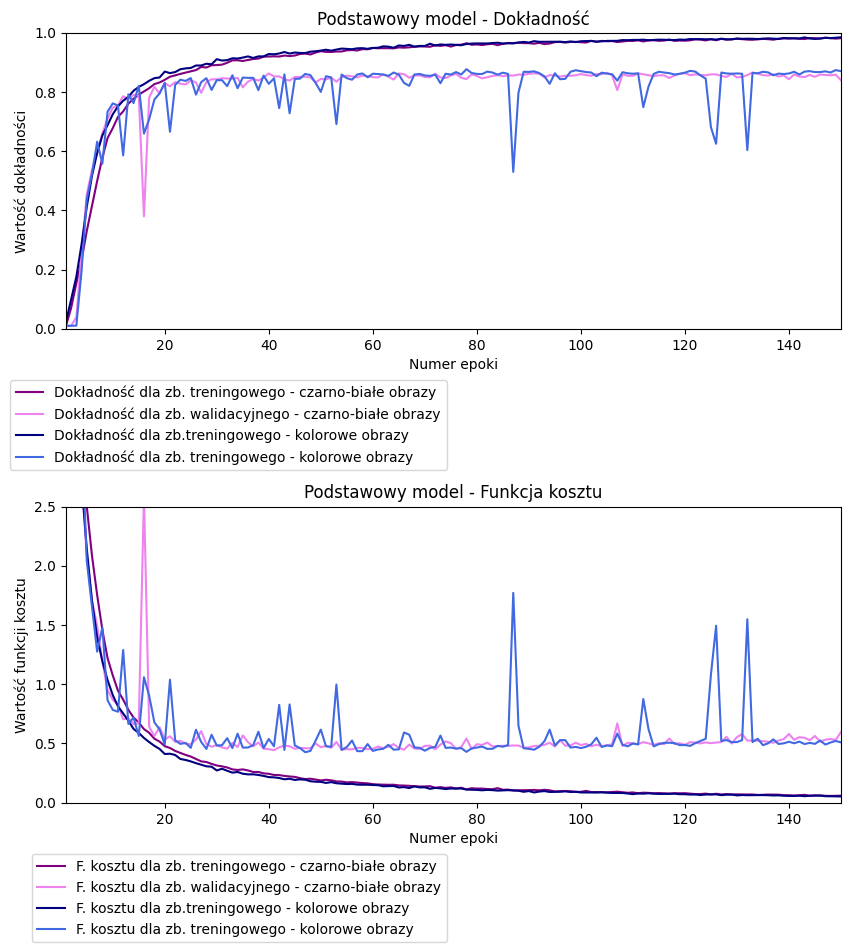

In [ ]:
plot_params(res_bw, res_c, 'Podstawowy model')

In [ ]:
def get_augmentation_model(labels_len, channels_num=3):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.02),
        tf.keras.layers.RandomZoom([-0.15, 0]),
    ])

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(100, 100, channels_num)))
    model.add(data_augmentation)
    model.add(tf.keras.layers.Rescaling(scale=1./255))
    add_conv_block(model, 20, activation=tf.keras.activations.relu, dropout=0.1)
    model.add(tf.keras.layers.BatchNormalization())
    add_conv_block(model, 40, activation=tf.keras.activations.relu, dropout=0.2)
    model.add(tf.keras.layers.BatchNormalization())
    add_conv_block(model, 80, activation=tf.keras.activations.relu, dropout=0.3)
    model.add(tf.keras.layers.BatchNormalization())
    add_conv_block(model, 160, activation=tf.keras.activations.relu, dropout=0.4)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(labels_len, activation=tf.keras.activations.softmax))
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])
    return model

In [ ]:
res_c_2 = run_model(get_augmentation_model(d_col.labels_len), d_col)
res_bw_2 = run_model(get_augmentation_model(d_bw.labels_len, 1), d_bw)

Epoch 1/150
152/152 [==============================] - 12s 65ms/step - loss: 5.4662 - accuracy: 0.0100 - val_loss: 4.7215 - val_accuracy: 0.0103
Epoch 2/150
152/152 [==============================] - 9s 61ms/step - loss: 5.3514 - accuracy: 0.0090 - val_loss: 4.7971 - val_accuracy: 0.0103
Epoch 3/150
152/152 [==============================] - 9s 60ms/step - loss: 5.1841 - accuracy: 0.0102 - val_loss: 4.6708 - val_accuracy: 0.0103
Epoch 4/150
152/152 [==============================] - 9s 62ms/step - loss: 5.0963 - accuracy: 0.0094 - val_loss: 4.6905 - val_accuracy: 0.0103
Epoch 5/150
152/152 [==============================] - 9s 58ms/step - loss: 5.0564 - accuracy: 0.0099 - val_loss: 4.6908 - val_accuracy: 0.0103
Epoch 6/150
152/152 [==============================] - 9s 59ms/step - loss: 5.0246 - accuracy: 0.0104 - val_loss: 4.6799 - val_accuracy: 0.0103
Epoch 7/150
152/152 [==============================] - 9s 60ms/step - loss: 4.9842 - accuracy: 0.0098 - val_loss: 4.6193 - val_accuracy

In [ ]:
dump_res(res_bw_2, res_c_2)

0.8680412173271179 [0.010309278033673763, 0.010309278033673763, 0.010309278033673763, 0.03865979239344597, 0.03814433142542839, 0.24896907806396484, 0.19793814420700073, 0.08350515365600586, 0.5139175057411194, 0.45824742317199707, 0.4283505082130432, 0.27835050225257874, 0.7402061820030212, 0.7092783451080322, 0.38711339235305786, 0.7329896688461304, 0.14587628841400146, 0.32680413126945496, 0.7742267847061157, 0.7783505320549011, 0.6701030731201172, 0.8123711347579956, 0.7762886881828308, 0.4757731854915619, 0.8211340308189392, 0.6030927896499634, 0.8180412650108337, 0.830927848815918, 0.7402061820030212, 0.811855673789978, 0.34690722823143005, 0.8180412650108337, 0.8144329786300659, 0.8231958746910095, 0.6061855554580688, 0.5613402128219604, 0.6242268085479736, 0.8417525887489319, 0.8407216668128967, 0.11082474142313004, 0.8443298935890198, 0.3438144326210022, 0.8278350234031677, 0.8247422575950623, 0.8469071984291077, 0.8505154848098755, 0.8340206146240234, 0.5695876479148865, 0.78

In [ ]:
#0.8680412173271179 [0.010309278033673763, 0.010309278033673763, 0.010309278033673763, 0.03865979239344597, 0.03814433142542839, 0.24896907806396484, 0.19793814420700073, 0.08350515365600586, 0.5139175057411194, 0.45824742317199707, 0.4283505082130432, 0.27835050225257874, 0.7402061820030212, 0.7092783451080322, 0.38711339235305786, 0.7329896688461304, 0.14587628841400146, 0.32680413126945496, 0.7742267847061157, 0.7783505320549011, 0.6701030731201172, 0.8123711347579956, 0.7762886881828308, 0.4757731854915619, 0.8211340308189392, 0.6030927896499634, 0.8180412650108337, 0.830927848815918, 0.7402061820030212, 0.811855673789978, 0.34690722823143005, 0.8180412650108337, 0.8144329786300659, 0.8231958746910095, 0.6061855554580688, 0.5613402128219604, 0.6242268085479736, 0.8417525887489319, 0.8407216668128967, 0.11082474142313004, 0.8443298935890198, 0.3438144326210022, 0.8278350234031677, 0.8247422575950623, 0.8469071984291077, 0.8505154848098755, 0.8340206146240234, 0.5695876479148865, 0.7819587588310242, 0.7814432978630066, 0.8402062058448792, 0.8520618677139282, 0.8489691019058228, 0.8546391725540161, 0.8278350234031677, 0.8469071984291077, 0.8530927896499634, 0.8520618677139282, 0.7778350710868835, 0.8376288414001465, 0.8402062058448792, 0.8283505439758301, 0.8551546335220337, 0.7597938179969788, 0.8314433097839355, 0.8458762764930725, 0.8396907448768616, 0.8494845628738403, 0.7469072341918945, 0.7865979671478271, 0.8551546335220337, 0.8546391725540161, 0.8556700944900513, 0.8432989716529846, 0.8520618677139282, 0.8592783212661743, 0.8479381203651428, 0.8649484515190125, 0.8551546335220337, 0.8494845628738403, 0.8577319383621216, 0.8546391725540161, 0.8556700944900513, 0.853608250617981, 0.8505154848098755, 0.7654638886451721, 0.8407216668128967, 0.8510309457778931, 0.8500000238418579, 0.8386598229408264, 0.857216477394104, 0.8582473993301392, 0.8551546335220337, 0.8613402247428894, 0.8587628602981567, 0.8515464067459106, 0.8551546335220337, 0.8561855554580688, 0.8515464067459106, 0.8597938418388367, 0.8515464067459106, 0.7618556618690491, 0.8613402247428894, 0.8505154848098755, 0.8505154848098755, 0.8623711466789246, 0.32525771856307983, 0.8288660049438477, 0.8639175295829773, 0.8505154848098755, 0.8582473993301392, 0.8515464067459106, 0.8525773286819458, 0.8505154848098755, 0.8582473993301392, 0.8376288414001465, 0.8561855554580688, 0.8639175295829773, 0.8561855554580688, 0.8623711466789246, 0.8613402247428894, 0.8664948344230652, 0.8144329786300659, 0.8546391725540161, 0.8608247637748718, 0.861855685710907, 0.8010309338569641, 0.8597938418388367, 0.8396907448768616, 0.8603093028068542, 0.8505154848098755, 0.6597937941551208, 0.8587628602981567, 0.8530927896499634, 0.8520618677139282, 0.8448453545570374, 0.8371133804321289, 0.8530927896499634, 0.8273195624351501, 0.8577319383621216, 0.820103108882904, 0.8567010164260864, 0.8123711347579956, 0.8525773286819458, 0.8680412173271179, 0.8525773286819458, 0.8587628602981567, 0.853608250617981, 0.861855685710907, 0.8608247637748718]
#0.9562886357307434 [0.010618556290864944, 0.010412370786070824, 0.0109278354793787, 0.025567010045051575, 0.09185566753149033, 0.1663917452096939, 0.28247421979904175, 0.4061855673789978, 0.5072165131568909, 0.5841237306594849, 0.6317525506019592, 0.6664948463439941, 0.6897938251495361, 0.7143298983573914, 0.7360824942588806, 0.7525773048400879, 0.7678350806236267, 0.776701033115387, 0.7906185388565063, 0.7997938394546509, 0.8131958842277527, 0.8121649622917175, 0.8215463757514954, 0.8281443119049072, 0.8360824584960938, 0.8354639410972595, 0.842164933681488, 0.8521649241447449, 0.850206196308136, 0.8559793829917908, 0.8602061867713928, 0.8669072389602661, 0.8624742031097412, 0.8635051250457764, 0.87226802110672, 0.8721649646759033, 0.8755670189857483, 0.8768041133880615, 0.880515456199646, 0.884742259979248, 0.8883504867553711, 0.8865979313850403, 0.8872165083885193, 0.8944329619407654, 0.8947422504425049, 0.8936082720756531, 0.891546368598938, 0.8982474207878113, 0.900412380695343, 0.8990721702575684, 0.9043298959732056, 0.9036082625389099, 0.9034020900726318, 0.9046391844749451, 0.9104123711585999, 0.9073196053504944, 0.9097937941551208, 0.9063917398452759, 0.9115464091300964, 0.9115464091300964, 0.9187628626823425, 0.9128866195678711, 0.9151546359062195, 0.919072151184082, 0.9209278225898743, 0.918247401714325, 0.9172164797782898, 0.9206185340881348, 0.923092782497406, 0.9206185340881348, 0.9221649765968323, 0.9223711490631104, 0.9212371110916138, 0.9214432835578918, 0.9220618605613708, 0.9256700873374939, 0.9275257587432861, 0.9281443357467651, 0.9253607988357544, 0.9285566806793213, 0.9279381632804871, 0.9288659691810608, 0.9296907186508179, 0.9297938346862793, 0.9297938346862793, 0.9325773119926453, 0.9315463900566101, 0.9303092956542969, 0.9332989454269409, 0.9339175224304199, 0.9336082339286804, 0.9324742555618286, 0.9331958889961243, 0.9348453879356384, 0.9337113499641418, 0.9386597871780396, 0.9374226927757263, 0.9370102882385254, 0.9409278631210327, 0.9352577328681946, 0.9425773024559021, 0.9392783641815186, 0.9418556690216064, 0.942371129989624, 0.9379381537437439, 0.9379381537437439, 0.9410309195518494, 0.9393814206123352, 0.9452577233314514, 0.9453608393669128, 0.9418556690216064, 0.9437113404273987, 0.9414433240890503, 0.9451546669006348, 0.9446391463279724, 0.9425773024559021, 0.9411340355873108, 0.9489690661430359, 0.9444329738616943, 0.942164957523346, 0.942783534526825, 0.9428865909576416, 0.9508247375488281, 0.9460824728012085, 0.9492783546447754, 0.9484536051750183, 0.9492783546447754, 0.9476288557052612, 0.9525772929191589, 0.9484536051750183, 0.946391761302948, 0.9464948177337646, 0.9473195672035217, 0.9508247375488281, 0.9525772929191589, 0.951237142086029, 0.9479381442070007, 0.9514433145523071, 0.9502061605453491, 0.9503092765808105, 0.9489690661430359, 0.949175238609314, 0.9489690661430359, 0.9562886357307434, 0.9514433145523071, 0.9520618319511414, 0.9542267918586731, 0.9545360803604126, 0.9539175033569336, 0.9489690661430359]
#0.43003204464912415 [4.745825290679932, 4.762540340423584, 4.711411952972412, 4.345087051391602, 5.5783796310424805, 2.9667632579803467, 3.115699052810669, 6.137138843536377, 1.7846931219100952, 1.8610846996307373, 2.034653902053833, 3.0729944705963135, 0.8859391212463379, 0.9810285568237305, 2.351158618927002, 0.8638097047805786, 5.449408531188965, 2.9106359481811523, 0.7259829640388489, 0.6783745288848877, 1.0602754354476929, 0.5765458941459656, 0.7124801278114319, 1.8867688179016113, 0.5394971966743469, 1.3204879760742188, 0.5544634461402893, 0.5359702706336975, 0.8096179962158203, 0.5724143981933594, 2.895366907119751, 0.5366762280464172, 0.5662866830825806, 0.5193026065826416, 1.3442623615264893, 1.661894679069519, 1.2601771354675293, 0.47869256138801575, 0.4907642900943756, 8.069296836853027, 0.475931316614151, 3.1509170532226562, 0.5356141328811646, 0.5591732859611511, 0.47329181432724, 0.4529514014720917, 0.4964923858642578, 1.6020658016204834, 0.6892728805541992, 0.717659056186676, 0.45637014508247375, 0.43924450874328613, 0.4444567561149597, 0.47377243638038635, 0.5686240196228027, 0.46124356985092163, 0.4601198136806488, 0.43148690462112427, 0.7345235347747803, 0.5029196739196777, 0.4994102418422699, 0.540310263633728, 0.4561772346496582, 0.7314282655715942, 0.5127192139625549, 0.4612404704093933, 0.49619218707084656, 0.45711126923561096, 0.8592532277107239, 0.6804205179214478, 0.43793705105781555, 0.47657203674316406, 0.43755289912223816, 0.463081419467926, 0.44767865538597107, 0.4427160918712616, 0.47911274433135986, 0.43097779154777527, 0.43003204464912415, 0.45870620012283325, 0.43064215779304504, 0.44945573806762695, 0.4549206495285034, 0.4574735164642334, 0.4699857532978058, 0.7408159375190735, 0.5194661617279053, 0.4646124243736267, 0.4588928520679474, 0.5198799967765808, 0.45585957169532776, 0.4682104289531708, 0.4426705241203308, 0.4325082302093506, 0.45255234837532043, 0.45837587118148804, 0.4590891897678375, 0.4730207920074463, 0.4840565025806427, 0.4455738067626953, 0.4599202573299408, 0.9058484435081482, 0.4650340676307678, 0.48959630727767944, 0.4951205253601074, 0.44977906346321106, 4.493933200836182, 0.5798683762550354, 0.4528740346431732, 0.48686689138412476, 0.4607444703578949, 0.493925005197525, 0.46629589796066284, 0.48288747668266296, 0.471266508102417, 0.5358479022979736, 0.45046448707580566, 0.4574001133441925, 0.4913175106048584, 0.4552466571331024, 0.472666472196579, 0.4414195120334625, 0.5651454925537109, 0.4918079078197479, 0.4458867609500885, 0.46392080187797546, 0.6273279190063477, 0.46518129110336304, 0.5665523409843445, 0.4581069350242615, 0.4854380190372467, 1.2741057872772217, 0.48921093344688416, 0.5025021433830261, 0.45795947313308716, 0.49385225772857666, 0.5216580629348755, 0.4945138692855835, 0.6237893104553223, 0.4449513852596283, 0.5934951901435852, 0.4582112431526184, 0.6072112321853638, 0.48808902502059937, 0.4433458149433136, 0.4796803593635559, 0.4850837290287018, 0.5262497663497925, 0.46847525238990784, 0.4656709134578705]
#0.119206503033638 [5.4438605308532715, 5.267012596130371, 5.104630947113037, 4.712915897369385, 3.992196798324585, 3.437758207321167, 2.8214128017425537, 2.257600784301758, 1.7993637323379517, 1.4895660877227783, 1.2795131206512451, 1.1292365789413452, 1.0251892805099487, 0.9373618960380554, 0.8656503558158875, 0.8101459741592407, 0.744504451751709, 0.7064157128334045, 0.6602185964584351, 0.6282567381858826, 0.5876423120498657, 0.583601176738739, 0.5596256256103516, 0.5263879895210266, 0.5115132331848145, 0.4980771839618683, 0.4699016809463501, 0.44842788577079773, 0.4508514106273651, 0.4310067296028137, 0.4178731143474579, 0.39576125144958496, 0.4023379683494568, 0.40564417839050293, 0.3698124289512634, 0.3695507049560547, 0.354404091835022, 0.3587164878845215, 0.34464237093925476, 0.3333936929702759, 0.3232637643814087, 0.3213483393192291, 0.3198905885219574, 0.3084663450717926, 0.3091290593147278, 0.3006029725074768, 0.3119504749774933, 0.2859201431274414, 0.28587430715560913, 0.28222960233688354, 0.2728641927242279, 0.2751120626926422, 0.2756898105144501, 0.2724536061286926, 0.24940750002861023, 0.25990068912506104, 0.2575433552265167, 0.2558111250400543, 0.24790532886981964, 0.2468561977148056, 0.23193354904651642, 0.24215850234031677, 0.2366188019514084, 0.22961491346359253, 0.22501254081726074, 0.22891028225421906, 0.22773872315883636, 0.22127756476402283, 0.21887703239917755, 0.2181982696056366, 0.21206970512866974, 0.217932790517807, 0.21826548874378204, 0.21216771006584167, 0.21079646050930023, 0.2025919407606125, 0.20070259273052216, 0.19650933146476746, 0.2004007250070572, 0.20136837661266327, 0.19225530326366425, 0.19287283718585968, 0.18951743841171265, 0.193161740899086, 0.1938926726579666, 0.18357421457767487, 0.1879148930311203, 0.18599195778369904, 0.18859384953975677, 0.18421980738639832, 0.17730611562728882, 0.18084625899791718, 0.1798821985721588, 0.17254889011383057, 0.17684811353683472, 0.16972221434116364, 0.17241838574409485, 0.16986416280269623, 0.16249744594097137, 0.1743590533733368, 0.16405659914016724, 0.1651775985956192, 0.15987378358840942, 0.16118428111076355, 0.16629467904567719, 0.1675342619419098, 0.16086922585964203, 0.1575881391763687, 0.15512852370738983, 0.15206708014011383, 0.15956608951091766, 0.15482354164123535, 0.15922412276268005, 0.1554078906774521, 0.15147416293621063, 0.15335461497306824, 0.15661250054836273, 0.1437651365995407, 0.1508726179599762, 0.150107741355896, 0.15204305946826935, 0.15020976960659027, 0.1373310685157776, 0.14309965074062347, 0.13704578578472137, 0.13952118158340454, 0.14051899313926697, 0.1394372433423996, 0.13745805621147156, 0.1425240933895111, 0.1388857662677765, 0.1458004266023636, 0.14162053167819977, 0.13258175551891327, 0.1312681883573532, 0.1354028433561325, 0.13779115676879883, 0.1308736652135849, 0.13588100671768188, 0.13158901035785675, 0.1379549503326416, 0.1342015415430069, 0.13513030111789703, 0.12398252636194229, 0.12817859649658203, 0.12737815082073212, 0.1265215277671814, 0.119206503033638, 0.128353089094162, 0.13268135488033295]
#0.8592783212661743 [0.010309278033673763, 0.010309278033673763, 0.010309278033673763, 0.010309278033673763, 0.010309278033673763, 0.010309278033673763, 0.010309278033673763, 0.06288659572601318, 0.1293814480304718, 0.20463918149471283, 0.13659793138504028, 0.3298968970775604, 0.4489690661430359, 0.6128866076469421, 0.5355669856071472, 0.4216494858264923, 0.19948454201221466, 0.741752564907074, 0.7159793972969055, 0.7654638886451721, 0.722680389881134, 0.7489690780639648, 0.7860824465751648, 0.6530928015708923, 0.7639175057411194, 0.0871134027838707, 0.7963917255401611, 0.05309278517961502, 0.7958762645721436, 0.07216494530439377, 0.7912371158599854, 0.7886598110198975, 0.059278350323438644, 0.7814432978630066, 0.6793814301490784, 0.6943299174308777, 0.8030927777290344, 0.8025773167610168, 0.7979381680488586, 0.7783505320549011, 0.8190721869468689, 0.8268041014671326, 0.8252577185630798, 0.839175283908844, 0.8304123878479004, 0.5407216548919678, 0.13350515067577362, 0.6505154371261597, 0.8381443023681641, 0.3907216489315033, 0.8324742317199707, 0.7695876359939575, 0.842783510684967, 0.8226804137229919, 0.8092783689498901, 0.8170102834701538, 0.7623711228370667, 0.834536075592041, 0.8273195624351501, 0.30721649527549744, 0.8448453545570374, 0.8350515365600586, 0.7927834987640381, 0.8500000238418579, 0.8494845628738403, 0.048969071358442307, 0.8298969268798828, 0.7623711228370667, 0.49690720438957214, 0.803608238697052, 0.8438144326210022, 0.8360824584960938, 0.6206185817718506, 0.8412371277809143, 0.023711340501904488, 0.8304123878479004, 0.8283505439758301, 0.8396907448768616, 0.8484535813331604, 0.8185567259788513, 0.8396907448768616, 0.8432989716529846, 0.8231958746910095, 0.8458762764930725, 0.830927848815918, 0.8541237115859985, 0.7695876359939575, 0.8515464067459106, 0.8592783212661743, 0.7886598110198975, 0.8412371277809143, 0.8371133804321289, 0.8474226593971252, 0.8170102834701538, 0.8489691019058228, 0.842783510684967, 0.8525773286819458, 0.10773196071386337, 0.495876282453537, 0.8453608155250549, 0.8257731795310974, 0.8412371277809143, 0.8412371277809143, 0.830927848815918, 0.13092783093452454, 0.8335051536560059, 0.15051546692848206, 0.2994845509529114, 0.800000011920929, 0.7948453426361084, 0.8443298935890198, 0.07319587469100952, 0.800000011920929, 0.8407216668128967, 0.6670103073120117, 0.8551546335220337, 0.8551546335220337, 0.1072164922952652, 0.8530927896499634, 0.2654639184474945, 0.8257731795310974, 0.7886598110198975, 0.8510309457778931, 0.13762886822223663, 0.8453608155250549, 0.8417525887489319, 0.8087629079818726, 0.18814432621002197, 0.820103108882904, 0.8546391725540161, 0.8567010164260864, 0.5123711228370667, 0.8458762764930725, 0.6716494560241699, 0.23041236400604248, 0.820103108882904, 0.8474226593971252, 0.8541237115859985, 0.8489691019058228, 0.853608250617981, 0.8412371277809143, 0.8195876479148865, 0.7134020328521729, 0.8463917374610901, 0.8407216668128967, 0.8546391725540161, 0.36701029539108276, 0.8582473993301392, 0.8525773286819458, 0.8402062058448792]
#0.9557731747627258 [0.009999999776482582, 0.008969072252511978, 0.010206185281276703, 0.00938144326210022, 0.009896907024085522, 0.010412370786070824, 0.009793814271688461, 0.024845361709594727, 0.09371133893728256, 0.15845361351966858, 0.22340206801891327, 0.33546391129493713, 0.4490721523761749, 0.5313401818275452, 0.5992783308029175, 0.6518556475639343, 0.6772164702415466, 0.7035051584243774, 0.7358762621879578, 0.7550515532493591, 0.7671133875846863, 0.783711314201355, 0.7988659739494324, 0.8061855435371399, 0.8107216358184814, 0.8175257444381714, 0.823298990726471, 0.8337113261222839, 0.8401030898094177, 0.8446391820907593, 0.8469071984291077, 0.854433000087738, 0.8601030707359314, 0.8657732009887695, 0.86546391248703, 0.8663917779922485, 0.8739175200462341, 0.8711340427398682, 0.8745360970497131, 0.8796907067298889, 0.8797938227653503, 0.8836082220077515, 0.8821649551391602, 0.8908247351646423, 0.8918556571006775, 0.8897938132286072, 0.8911340236663818, 0.892783522605896, 0.8951546549797058, 0.8920618295669556, 0.8999999761581421, 0.8989690542221069, 0.9010308980941772, 0.9018556475639343, 0.9058762788772583, 0.9060824513435364, 0.9041237235069275, 0.9084535837173462, 0.9121649265289307, 0.9128866195678711, 0.9113401770591736, 0.9106185436248779, 0.9104123711585999, 0.9180412292480469, 0.9140205979347229, 0.9180412292480469, 0.9151546359062195, 0.9156700968742371, 0.9195876121520996, 0.9244329929351807, 0.9195876121520996, 0.9215463995933533, 0.9236082434654236, 0.9247422814369202, 0.9220618605613708, 0.9297938346862793, 0.9274227023124695, 0.9257732033729553, 0.926494836807251, 0.925876259803772, 0.9259793758392334, 0.926494836807251, 0.9297938346862793, 0.9323711395263672, 0.9291752576828003, 0.9284536242485046, 0.9324742555618286, 0.9352577328681946, 0.9365979433059692, 0.9342268109321594, 0.9314432740211487, 0.9337113499641418, 0.9310309290885925, 0.9355670213699341, 0.9377319812774658, 0.9344329833984375, 0.9328866004943848, 0.9357731938362122, 0.9351546168327332, 0.9367010593414307, 0.9412370920181274, 0.9402061700820923, 0.9379381537437439, 0.9454638957977295, 0.9436082243919373, 0.9414433240890503, 0.9386597871780396, 0.9413402080535889, 0.9383504986763, 0.942164957523346, 0.9401031136512756, 0.9435051679611206, 0.9465979337692261, 0.9403092861175537, 0.9453608393669128, 0.9408247470855713, 0.9437113404273987, 0.9486597776412964, 0.9440206289291382, 0.9450515508651733, 0.9449484348297119, 0.9461855888366699, 0.9487628936767578, 0.950412392616272, 0.9482474327087402, 0.9480412602424622, 0.9469072222709656, 0.9468041062355042, 0.9510309100151062, 0.9485567212104797, 0.9508247375488281, 0.9484536051750183, 0.9471133947372437, 0.9486597776412964, 0.953402042388916, 0.9515463709831238, 0.9509278535842896, 0.9519587755203247, 0.9484536051750183, 0.950412392616272, 0.9493814706802368, 0.9509278535842896, 0.949999988079071, 0.9517526030540466, 0.9502061605453491, 0.9521649479866028, 0.9535051584243774, 0.9528865814208984, 0.9557731747627258, 0.9517526030540466]
#0.43099793791770935 [4.721513271331787, 4.797076225280762, 4.670849323272705, 4.690464973449707, 4.6907782554626465, 4.679905891418457, 4.619250774383545, 3.998107671737671, 3.604365825653076, 3.2486186027526855, 3.4403491020202637, 2.6783738136291504, 2.1145193576812744, 1.4787592887878418, 1.6185187101364136, 1.9634284973144531, 3.6668663024902344, 0.8677809238433838, 0.9312911033630371, 0.7473168969154358, 0.8734287619590759, 0.7610507607460022, 0.6554045081138611, 1.1391615867614746, 0.7231563329696655, 7.717740058898926, 0.6433029770851135, 9.83743953704834, 0.5834310054779053, 8.946006774902344, 0.6210126876831055, 0.6529554724693298, 10.35198974609375, 0.6509555578231812, 1.0133757591247559, 0.9804418683052063, 0.5979388952255249, 0.5810376405715942, 0.5991784334182739, 0.6962513327598572, 0.5267544984817505, 0.5158126354217529, 0.5043635368347168, 0.4741933345794678, 0.489605188369751, 1.6900153160095215, 6.009075164794922, 1.1105321645736694, 0.4692882299423218, 2.872502326965332, 0.48373937606811523, 0.7202664017677307, 0.48418354988098145, 0.4997919797897339, 0.5845237970352173, 0.555414617061615, 0.7660465240478516, 0.47815045714378357, 0.5157932043075562, 3.7036707401275635, 0.45769646763801575, 0.49128949642181396, 0.6428495049476624, 0.44653481245040894, 0.453541100025177, 11.155686378479004, 0.5109059810638428, 0.794291079044342, 2.2367444038391113, 0.5684084892272949, 0.45257511734962463, 0.4816153645515442, 1.2825669050216675, 0.4703589081764221, 18.10892105102539, 0.5047791004180908, 0.5121504068374634, 0.4592950642108917, 0.4380010664463043, 0.577401876449585, 0.49084165692329407, 0.45152607560157776, 0.5337091684341431, 0.4505888819694519, 0.49260213971138, 0.4405093193054199, 0.745356023311615, 0.4318321645259857, 0.4427138566970825, 0.6993459463119507, 0.46360042691230774, 0.4783017635345459, 0.4433496296405792, 0.5757243037223816, 0.46596989035606384, 0.47719696164131165, 0.43099793791770935, 8.297674179077148, 2.6885132789611816, 0.44927510619163513, 0.5409228205680847, 0.4670703113079071, 0.48758891224861145, 0.5307036638259888, 6.575822830200195, 0.48510921001434326, 8.173784255981445, 4.499828815460205, 0.5966848731040955, 0.6487781405448914, 0.5011484026908875, 11.765410423278809, 0.6438663005828857, 0.5032256841659546, 1.2396987676620483, 0.47184625267982483, 0.47375205159187317, 9.641786575317383, 0.4490548372268677, 5.127839088439941, 0.5555119514465332, 0.6823874115943909, 0.452454149723053, 8.700695037841797, 0.465538889169693, 0.48826485872268677, 0.5898274183273315, 6.191367149353027, 0.604017436504364, 0.4325305223464966, 0.44840389490127563, 2.4808883666992188, 0.510449230670929, 1.1970641613006592, 5.209591865539551, 0.5978879928588867, 0.44877567887306213, 0.4594372510910034, 0.44150447845458984, 0.4602823257446289, 0.48115843534469604, 0.595035970211029, 0.9890468120574951, 0.4604714512825012, 0.4742201268672943, 0.4388672709465027, 4.129907131195068, 0.4402652382850647, 0.44619399309158325, 0.45592737197875977]
#0.1215759813785553 [5.466152667999268, 5.351416110992432, 5.18411111831665, 5.096251010894775, 5.0564374923706055, 5.02457857131958, 4.984197616577148, 4.724886417388916, 3.9002935886383057, 3.5052826404571533, 3.089245557785034, 2.5799267292022705, 2.094996929168701, 1.7135334014892578, 1.439820647239685, 1.2210361957550049, 1.0859086513519287, 0.9976750016212463, 0.8789265155792236, 0.8066679835319519, 0.7513776421546936, 0.697226881980896, 0.6495528817176819, 0.6136296987533569, 0.592003583908081, 0.5608481764793396, 0.5397048592567444, 0.5277484059333801, 0.49778681993484497, 0.4757325351238251, 0.4691252112388611, 0.44246309995651245, 0.4284728765487671, 0.4112769663333893, 0.40510526299476624, 0.3880721628665924, 0.3803916275501251, 0.36749324202537537, 0.3609413802623749, 0.3566848933696747, 0.3435443043708801, 0.34161484241485596, 0.33837899565696716, 0.31871047616004944, 0.3170870244503021, 0.3190116584300995, 0.30968791246414185, 0.3063978850841522, 0.2925213575363159, 0.29792481660842896, 0.28262266516685486, 0.2854064702987671, 0.280508816242218, 0.2735925018787384, 0.268045037984848, 0.2661159634590149, 0.2669597566127777, 0.25581762194633484, 0.2523457705974579, 0.25067752599716187, 0.24545925855636597, 0.2495499551296234, 0.24572797119617462, 0.23494327068328857, 0.24061772227287292, 0.2330557107925415, 0.2350960224866867, 0.2223997563123703, 0.22484329342842102, 0.21514523029327393, 0.21701987087726593, 0.21623283624649048, 0.21635355055332184, 0.20469334721565247, 0.20632080733776093, 0.1997387409210205, 0.2044401913881302, 0.20132902264595032, 0.20403721928596497, 0.20597386360168457, 0.1991492509841919, 0.20634448528289795, 0.19390550255775452, 0.18908917903900146, 0.18819847702980042, 0.19185316562652588, 0.1830587089061737, 0.18253633379936218, 0.18054291605949402, 0.1804930567741394, 0.18102975189685822, 0.18484322726726532, 0.18371205031871796, 0.17163309454917908, 0.1720038652420044, 0.16964583098888397, 0.17378182709217072, 0.16954682767391205, 0.1724318265914917, 0.17309394478797913, 0.16217784583568573, 0.16770344972610474, 0.1646963357925415, 0.15762624144554138, 0.1526917964220047, 0.16564252972602844, 0.160953551530838, 0.15872453153133392, 0.16596345603466034, 0.15253664553165436, 0.15897582471370697, 0.15552166104316711, 0.1466522514820099, 0.15921755135059357, 0.1501021832227707, 0.15653462707996368, 0.15367341041564941, 0.14502675831317902, 0.15038523077964783, 0.147510826587677, 0.14466138184070587, 0.13930575549602509, 0.14026081562042236, 0.13477641344070435, 0.14189273118972778, 0.1399429589509964, 0.13798117637634277, 0.1443610042333603, 0.13512785732746124, 0.13907891511917114, 0.1341772824525833, 0.14167705178260803, 0.13820461928844452, 0.1412855088710785, 0.13011394441127777, 0.13272733986377716, 0.12914669513702393, 0.1350446492433548, 0.1359652280807495, 0.12990479171276093, 0.13492782413959503, 0.13223589956760406, 0.13387390971183777, 0.12626507878303528, 0.1306767761707306, 0.13026827573776245, 0.12498084455728531, 0.1215759813785553, 0.1238805428147316, 0.12627466022968292]

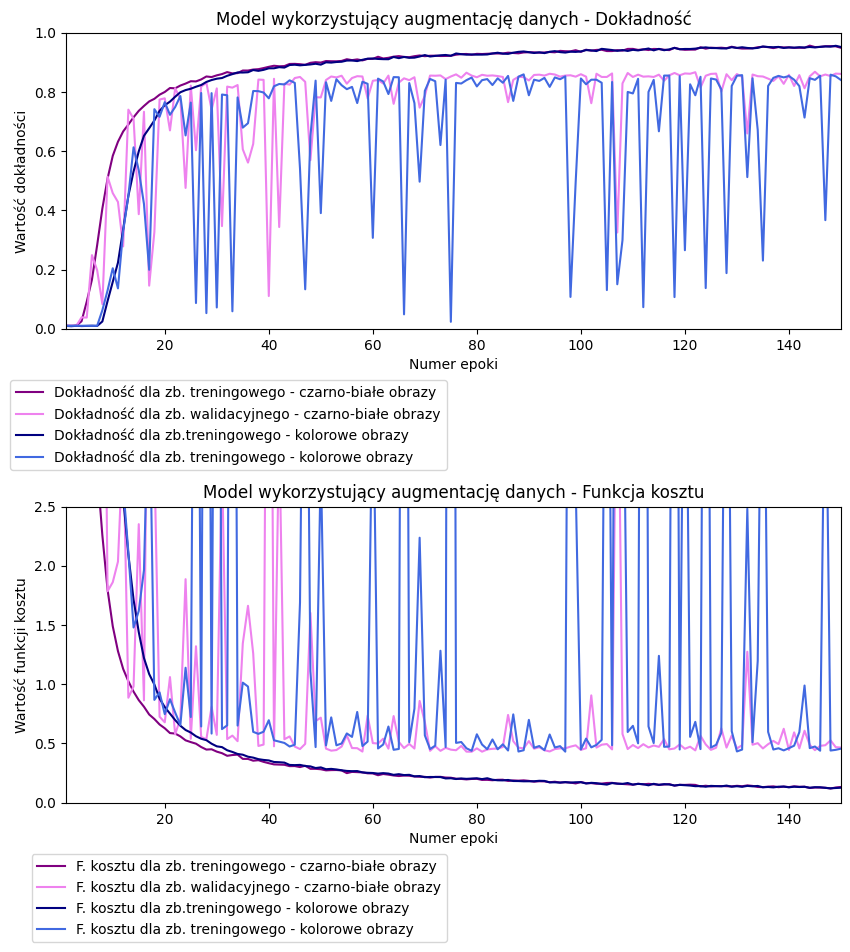

In [ ]:
plot_params(res_bw_2, res_c_2, 'Model wykorzystujący augmentację danych')

In [28]:
def get_transfer_based_model(labels_len, base_model):
    inputs = tf.keras.Input(shape=(100, 100, 3))
    base_model.trainable = False
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(labels_len, activation=tf.keras.activations.softmax)(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

    return model

In [ ]:
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(100, 100, 3),
                                               include_top=False,
                                               weights='imagenet')
res_c_3 = run_model(get_transfer_based_model(d_col.labels_len, base_model), d_col)
res_bw_3 = run_model(get_transfer_based_model(d_bw_3.labels_len, base_model), d_bw_3)

Epoch 1/150
152/152 [==============================] - 17s 75ms/step - loss: 0.2375 - accuracy: 0.0078 - val_loss: 0.0818 - val_accuracy: 0.0082
Epoch 2/150
152/152 [==============================] - 10s 68ms/step - loss: 0.0736 - accuracy: 0.0119 - val_loss: 0.0636 - val_accuracy: 0.0196
Epoch 3/150
152/152 [==============================] - 10s 63ms/step - loss: 0.0634 - accuracy: 0.0288 - val_loss: 0.0588 - val_accuracy: 0.0557
Epoch 4/150
152/152 [==============================] - 11s 71ms/step - loss: 0.0595 - accuracy: 0.0523 - val_loss: 0.0559 - val_accuracy: 0.0964
Epoch 5/150
152/152 [==============================] - 9s 62ms/step - loss: 0.0565 - accuracy: 0.0830 - val_loss: 0.0535 - val_accuracy: 0.1428
Epoch 6/150
152/152 [==============================] - 10s 69ms/step - loss: 0.0541 - accuracy: 0.1170 - val_loss: 0.0514 - val_accuracy: 0.2082
Epoch 7/150
152/152 [==============================] - 9s 62ms/step - loss: 0.0517 - accuracy: 0.1555 - val_loss: 0.0494 - val_accu

In [ ]:
dump_res(res_bw_3, res_c_3)

0.6907216310501099 [0.011855670250952244, 0.022164948284626007, 0.051030926406383514, 0.0804123729467392, 0.11443299055099487, 0.16134020686149597, 0.19329896569252014, 0.2278350442647934, 0.2505154609680176, 0.28247421979904175, 0.3061855733394623, 0.3237113356590271, 0.3463917672634125, 0.36494845151901245, 0.37783506512641907, 0.39639174938201904, 0.42525774240493774, 0.4304123818874359, 0.446391761302948, 0.45463916659355164, 0.46597936749458313, 0.46546390652656555, 0.4824742376804352, 0.49639174342155457, 0.5, 0.5025773048400879, 0.5087628960609436, 0.5350515246391296, 0.5335051417350769, 0.5376288890838623, 0.5422680377960205, 0.5505154728889465, 0.557216465473175, 0.557216465473175, 0.5675257444381714, 0.5711340308189392, 0.5711340308189392, 0.580927848815918, 0.5804123878479004, 0.5912371277809143, 0.5902062058448792, 0.5907216668128967, 0.5958762764930725, 0.5943298935890198, 0.6020618677139282, 0.6025773286819458, 0.6046391725540161, 0.6046391725540161, 0.6097938418388367, 0

In [ ]:
#0.6907216310501099 [0.011855670250952244, 0.022164948284626007, 0.051030926406383514, 0.0804123729467392, 0.11443299055099487, 0.16134020686149597, 0.19329896569252014, 0.2278350442647934, 0.2505154609680176, 0.28247421979904175, 0.3061855733394623, 0.3237113356590271, 0.3463917672634125, 0.36494845151901245, 0.37783506512641907, 0.39639174938201904, 0.42525774240493774, 0.4304123818874359, 0.446391761302948, 0.45463916659355164, 0.46597936749458313, 0.46546390652656555, 0.4824742376804352, 0.49639174342155457, 0.5, 0.5025773048400879, 0.5087628960609436, 0.5350515246391296, 0.5335051417350769, 0.5376288890838623, 0.5422680377960205, 0.5505154728889465, 0.557216465473175, 0.557216465473175, 0.5675257444381714, 0.5711340308189392, 0.5711340308189392, 0.580927848815918, 0.5804123878479004, 0.5912371277809143, 0.5902062058448792, 0.5907216668128967, 0.5958762764930725, 0.5943298935890198, 0.6020618677139282, 0.6025773286819458, 0.6046391725540161, 0.6046391725540161, 0.6097938418388367, 0.6113402247428894, 0.6180412173271179, 0.6134020686149597, 0.6134020686149597, 0.6190721392631531, 0.6180412173271179, 0.623711347579956, 0.6309278607368469, 0.6340206265449524, 0.620103120803833, 0.6319587826728821, 0.6309278607368469, 0.6386597752571106, 0.63453608751297, 0.63453608751297, 0.6417526006698608, 0.6417526006698608, 0.6376288533210754, 0.6376288533210754, 0.6391752362251282, 0.6432989835739136, 0.6453608274459839, 0.6489690542221069, 0.6484535932540894, 0.642783522605896, 0.6479381322860718, 0.6432989835739136, 0.6453608274459839, 0.6515464186668396, 0.6489690542221069, 0.6489690542221069, 0.6525773406028748, 0.6510308980941772, 0.6556701064109802, 0.6592783331871033, 0.6597937941551208, 0.6587628722190857, 0.6556701064109802, 0.6530928015708923, 0.6582474112510681, 0.6634020805358887, 0.6613401770591736, 0.6603092551231384, 0.6603092551231384, 0.6618556976318359, 0.6695876121520996, 0.6618556976318359, 0.6659793853759766, 0.6659793853759766, 0.6680412292480469, 0.665463924407959, 0.6680412292480469, 0.6726804375648499, 0.6701030731201172, 0.6706185340881348, 0.6711339950561523, 0.6680412292480469, 0.665463924407959, 0.6768041253089905, 0.6731958985328674, 0.6711339950561523, 0.6762886643409729, 0.6747422814369202, 0.6716494560241699, 0.6762886643409729, 0.673711359500885, 0.6768041253089905, 0.6757732033729553, 0.6731958985328674, 0.679896891117096, 0.6793814301490784, 0.6819587349891663, 0.6814432740211487, 0.6819587349891663, 0.6793814301490784, 0.6804123520851135, 0.6835051774978638, 0.6845360994338989, 0.6840206384658813, 0.6845360994338989, 0.6824742555618286, 0.6809278130531311, 0.6835051774978638, 0.6835051774978638, 0.679896891117096, 0.6809278130531311, 0.6855670213699341, 0.6855670213699341, 0.6829897165298462, 0.6865979433059692, 0.6871134042739868, 0.6845360994338989, 0.6902061700820923, 0.6814432740211487, 0.6860824823379517, 0.6876288652420044, 0.6840206384658813, 0.6835051774978638, 0.6865979433059692, 0.6876288652420044, 0.6907216310501099]
#0.7838144302368164 [0.01350515428930521, 0.01608247496187687, 0.025773195549845695, 0.04134020581841469, 0.06567010283470154, 0.09298969060182571, 0.11525773257017136, 0.14226804673671722, 0.17855669558048248, 0.19515463709831238, 0.22515463829040527, 0.24432989954948425, 0.273298978805542, 0.28886598348617554, 0.31628865003585815, 0.33144330978393555, 0.346185564994812, 0.373608261346817, 0.38597938418388367, 0.40134021639823914, 0.4143298864364624, 0.43402060866355896, 0.445773184299469, 0.4583505094051361, 0.469072163105011, 0.4830927848815918, 0.4932989776134491, 0.4987628757953644, 0.511649489402771, 0.5215463638305664, 0.5291752815246582, 0.5388659834861755, 0.5446391701698303, 0.5549484491348267, 0.5583505034446716, 0.5676288604736328, 0.5759793519973755, 0.5821649432182312, 0.5841237306594849, 0.5855669975280762, 0.5964948534965515, 0.6068041324615479, 0.6041237115859985, 0.6087628602981567, 0.6177319884300232, 0.614639163017273, 0.626494824886322, 0.6256700754165649, 0.6299999952316284, 0.6314433217048645, 0.642783522605896, 0.646185576915741, 0.6511340141296387, 0.6482474207878113, 0.6530928015708923, 0.6579381227493286, 0.6562886834144592, 0.6612371206283569, 0.6629896759986877, 0.6671134233474731, 0.669072151184082, 0.6689690947532654, 0.6769072413444519, 0.6791752576828003, 0.6768041253089905, 0.684742271900177, 0.6814432740211487, 0.6910309195518494, 0.6857731938362122, 0.6926804184913635, 0.6918556690216064, 0.6913402080535889, 0.6954638957977295, 0.7005154490470886, 0.7010309100151062, 0.7086597681045532, 0.7067010402679443, 0.7011340260505676, 0.7042267918586731, 0.7097938060760498, 0.7058762907981873, 0.7127835154533386, 0.7131958603858948, 0.7141237258911133, 0.7088660001754761, 0.7165979146957397, 0.7170103192329407, 0.7187628746032715, 0.7242268323898315, 0.7243298888206482, 0.7281443476676941, 0.7250515222549438, 0.7254639267921448, 0.7276288866996765, 0.7305154800415039, 0.7326804399490356, 0.7316494584083557, 0.7292783260345459, 0.7296907305717468, 0.7378350496292114, 0.7394845485687256, 0.7401030659675598, 0.7415463924407959, 0.741958737373352, 0.7410309314727783, 0.7437113523483276, 0.7446391582489014, 0.7428866028785706, 0.7418556809425354, 0.7522680163383484, 0.7515463829040527, 0.7460824847221375, 0.7476288676261902, 0.7522680163383484, 0.7507216334342957, 0.7551546096801758, 0.758041262626648, 0.7575258016586304, 0.7553608417510986, 0.7583504915237427, 0.7629896998405457, 0.7586597800254822, 0.7632989883422852, 0.764432966709137, 0.7635051608085632, 0.7635051608085632, 0.7636082768440247, 0.7673195600509644, 0.7639175057411194, 0.7676288485527039, 0.7657731771469116, 0.7654638886451721, 0.768659770488739, 0.7696906924247742, 0.7712371349334717, 0.7704123854637146, 0.7745360732078552, 0.7746391892433167, 0.7728865742683411, 0.7783505320549011, 0.7746391892433167, 0.7719587683677673, 0.7762886881828308, 0.7791752815246582, 0.7796907424926758, 0.7780412435531616, 0.7819587588310242, 0.7838144302368164, 0.7827835083007812, 0.778144359588623]
#0.020942583680152893 [0.09093178808689117, 0.06563463062047958, 0.059880565851926804, 0.05708470195531845, 0.055005308240652084, 0.05320095643401146, 0.05152637138962746, 0.049972034990787506, 0.0485098622739315, 0.04713371396064758, 0.045877572149038315, 0.0446910597383976, 0.043594617396593094, 0.042561423033475876, 0.04161009192466736, 0.04071918874979019, 0.03987598046660423, 0.039067499339580536, 0.03832840919494629, 0.03762950003147125, 0.03695153445005417, 0.03629336878657341, 0.035711031407117844, 0.03513876348733902, 0.03458390757441521, 0.03407927230000496, 0.03359270468354225, 0.03311067819595337, 0.03266270086169243, 0.03226682171225548, 0.03183695673942566, 0.03145395219326019, 0.031085679307579994, 0.03073578141629696, 0.0304240845143795, 0.03008272685110569, 0.02977990359067917, 0.029498131945729256, 0.029197318479418755, 0.028939446434378624, 0.028677241876721382, 0.028452683240175247, 0.028234189376235008, 0.02797466330230236, 0.027759959921240807, 0.0275719091296196, 0.027399035170674324, 0.027187908068299294, 0.02701408974826336, 0.026820974424481392, 0.026654398068785667, 0.026497993618249893, 0.026352204382419586, 0.026160849258303642, 0.026065228506922722, 0.02589467540383339, 0.025809843093156815, 0.02565639838576317, 0.025522619485855103, 0.02540627308189869, 0.025282468646764755, 0.025169644504785538, 0.025074273347854614, 0.024949848651885986, 0.024836465716362, 0.02475076913833618, 0.02464693784713745, 0.024562876671552658, 0.024473214522004128, 0.02436847612261772, 0.024281540885567665, 0.024201950058341026, 0.024123601615428925, 0.024044029414653778, 0.02395877242088318, 0.02389238402247429, 0.023825787007808685, 0.023698510602116585, 0.023689022287726402, 0.02361387200653553, 0.023550530895590782, 0.023475078865885735, 0.02340906858444214, 0.023322690278291702, 0.0232708603143692, 0.023211097344756126, 0.023180479183793068, 0.023110313341021538, 0.023068146780133247, 0.022981634363532066, 0.022906828671693802, 0.022891880944371223, 0.022863464429974556, 0.02278987132012844, 0.022766534239053726, 0.02269243262708187, 0.022649776190519333, 0.02257666178047657, 0.02255123108625412, 0.022503459826111794, 0.022436227649450302, 0.02237849496304989, 0.022387202829122543, 0.02232842519879341, 0.022291535511612892, 0.02225523442029953, 0.02219477854669094, 0.02218042127788067, 0.022138157859444618, 0.022101910784840584, 0.022028110921382904, 0.022005809471011162, 0.021963251754641533, 0.021916968747973442, 0.02190566062927246, 0.021846504881978035, 0.02182658761739731, 0.021788129583001137, 0.02175816521048546, 0.021715469658374786, 0.021707264706492424, 0.02168501541018486, 0.021613353863358498, 0.021607255563139915, 0.021567007526755333, 0.021522914990782738, 0.021522564813494682, 0.0214675385504961, 0.021418392658233643, 0.021445486694574356, 0.02138373628258705, 0.021366547793149948, 0.021362578496336937, 0.021336251869797707, 0.021278085187077522, 0.021259667351841927, 0.021245086565613747, 0.021210327744483948, 0.021193036809563637, 0.021167146041989326, 0.02114531584084034, 0.02109714411199093, 0.021106591448187828, 0.021095704287290573, 0.0210699625313282, 0.021038012579083443, 0.02103637158870697, 0.020945196971297264, 0.02096658945083618, 0.020942583680152893]
#0.01664467342197895 [0.2710639536380768, 0.080839142203331, 0.06600337475538254, 0.06096786633133888, 0.05817189812660217, 0.056071650236845016, 0.053989775478839874, 0.052204206585884094, 0.05056704208254814, 0.04906727746129036, 0.04757801070809364, 0.04631029814481735, 0.04495946317911148, 0.04391007125377655, 0.04288819432258606, 0.04176576808094978, 0.04080871120095253, 0.03987378627061844, 0.0390101857483387, 0.038408003747463226, 0.037572264671325684, 0.03676188737154007, 0.03607363998889923, 0.03542713448405266, 0.03486628085374832, 0.034203797578811646, 0.03359648585319519, 0.033067021518945694, 0.0326152928173542, 0.03206448629498482, 0.03155791759490967, 0.031096959486603737, 0.03071066364645958, 0.030270328745245934, 0.029837822541594505, 0.029487472027540207, 0.029058828949928284, 0.02869127131998539, 0.028387118130922318, 0.028047580271959305, 0.027766909450292587, 0.027484413236379623, 0.027223192155361176, 0.026870954781770706, 0.026591835543513298, 0.026369310915470123, 0.026226209476590157, 0.025960609316825867, 0.02569335326552391, 0.025416674092411995, 0.025211188942193985, 0.024970700964331627, 0.024839360266923904, 0.02467028796672821, 0.02446545660495758, 0.02423030510544777, 0.024061650037765503, 0.023847054690122604, 0.02379663661122322, 0.023578321561217308, 0.023418031632900238, 0.02330676279962063, 0.02312580682337284, 0.022906392812728882, 0.022862685844302177, 0.02268192544579506, 0.02257494255900383, 0.022354470565915108, 0.022319423034787178, 0.02215954102575779, 0.02201843447983265, 0.021941928192973137, 0.021840419620275497, 0.021693704649806023, 0.02154824137687683, 0.021427443251013756, 0.02131819911301136, 0.02130182646214962, 0.021165411919355392, 0.02107192389667034, 0.021024232730269432, 0.020897330716252327, 0.02074385993182659, 0.02069643698632717, 0.020643990486860275, 0.02043594792485237, 0.020463887602090836, 0.02033388987183571, 0.020212188363075256, 0.02015153132379055, 0.020013432949781418, 0.01991928741335869, 0.019890224561095238, 0.01982126571238041, 0.019780252128839493, 0.019692381843924522, 0.019588464871048927, 0.019560931250452995, 0.01946769468486309, 0.019347209483385086, 0.019292285665869713, 0.01921936124563217, 0.019141748547554016, 0.01907164976000786, 0.019074847921729088, 0.018983013927936554, 0.018889475613832474, 0.018886230885982513, 0.01874586194753647, 0.018626665696501732, 0.018575971946120262, 0.018612343817949295, 0.01854155771434307, 0.018490495160222054, 0.01838799938559532, 0.018298977985978127, 0.01823456771671772, 0.018176499754190445, 0.018209438771009445, 0.018121259286999702, 0.01806478574872017, 0.017957085743546486, 0.0179178174585104, 0.017834249883890152, 0.017828186973929405, 0.01779591664671898, 0.01772598922252655, 0.01766711100935936, 0.017667727544903755, 0.017516033723950386, 0.0175782423466444, 0.01751326397061348, 0.017425144091248512, 0.01735934242606163, 0.017374930903315544, 0.017260944470763206, 0.0172220878303051, 0.017159348353743553, 0.017190923914313316, 0.017112979665398598, 0.017044594511389732, 0.017028719186782837, 0.016965817660093307, 0.01691308803856373, 0.016862807795405388, 0.016807781532406807, 0.01676880195736885, 0.01674269139766693, 0.01676764525473118, 0.01664467342197895]
#0.6793814301490784 [0.008247422985732555, 0.019587628543376923, 0.055670104920864105, 0.09639175236225128, 0.1427835077047348, 0.20824742317199707, 0.24020618200302124, 0.28402063250541687, 0.31804123520851135, 0.3510309159755707, 0.3711340129375458, 0.38762885332107544, 0.39587628841400146, 0.4067010283470154, 0.42783504724502563, 0.4216494858264923, 0.43453606963157654, 0.44793814420700073, 0.44793814420700073, 0.46288660168647766, 0.47886598110198975, 0.4912371039390564, 0.4953608214855194, 0.5015463829040527, 0.5061855912208557, 0.514432966709137, 0.5201030969619751, 0.5314432978630066, 0.5340206027030945, 0.5396907329559326, 0.5505154728889465, 0.5505154728889465, 0.5489690899848938, 0.557216465473175, 0.558247447013855, 0.5608247518539429, 0.5639175176620483, 0.5731958746910095, 0.5716494917869568, 0.5835051536560059, 0.5793814659118652, 0.5835051536560059, 0.5948453545570374, 0.589175283908844, 0.5948453545570374, 0.5979381203651428, 0.5974226593971252, 0.5979381203651428, 0.603608250617981, 0.6010309457778931, 0.6046391725540161, 0.6041237115859985, 0.6108247637748718, 0.6113402247428894, 0.607216477394104, 0.6170102953910828, 0.61546391248703, 0.6113402247428894, 0.6180412173271179, 0.6206185817718506, 0.6226804256439209, 0.6195876002311707, 0.6195876002311707, 0.6242268085479736, 0.629896879196167, 0.6247422695159912, 0.626288652420044, 0.6278350353240967, 0.6324742436408997, 0.6360824704170227, 0.6283504962921143, 0.6355670094490051, 0.6350515484809875, 0.6360824704170227, 0.6391752362251282, 0.638144314289093, 0.638144314289093, 0.6412371397018433, 0.6360824704170227, 0.6391752362251282, 0.642783522605896, 0.6458762884140015, 0.6438144445419312, 0.6443299055099487, 0.6402061581611633, 0.6448453664779663, 0.6422680616378784, 0.6458762884140015, 0.6484535932540894, 0.6505154371261597, 0.6505154371261597, 0.6505154371261597, 0.6505154371261597, 0.6515464186668396, 0.6525773406028748, 0.6546391844749451, 0.6510308980941772, 0.6567010283470154, 0.6577319502830505, 0.6546391844749451, 0.6556701064109802, 0.657216489315033, 0.6551546454429626, 0.6597937941551208, 0.660824716091156, 0.6618556976318359, 0.660824716091156, 0.6556701064109802, 0.6623711585998535, 0.6561855673789978, 0.6639175415039062, 0.6546391844749451, 0.6613401770591736, 0.6582474112510681, 0.665463924407959, 0.6675257682800293, 0.6644330024719238, 0.669072151184082, 0.6644330024719238, 0.6649484634399414, 0.6670103073120117, 0.6680412292480469, 0.6659793853759766, 0.6670103073120117, 0.6644330024719238, 0.6695876121520996, 0.6721649765968323, 0.6701030731201172, 0.669072151184082, 0.6675257682800293, 0.6711339950561523, 0.6757732033729553, 0.6701030731201172, 0.6731958985328674, 0.6793814301490784, 0.6711339950561523, 0.6752577424049377, 0.6783505082130432, 0.6747422814369202, 0.6762886643409729, 0.6695876121520996, 0.6721649765968323, 0.673711359500885, 0.6762886643409729, 0.6793814301490784, 0.6783505082130432, 0.6726804375648499, 0.6731958985328674, 0.6731958985328674, 0.6773195862770081]
#0.8250515460968018 [0.007835051976144314, 0.011855670250952244, 0.02876288630068302, 0.05226803943514824, 0.08298969268798828, 0.11701031029224396, 0.15546391904354095, 0.19010309875011444, 0.21432989835739136, 0.2479381412267685, 0.27402061223983765, 0.3024742305278778, 0.3205154538154602, 0.3535051643848419, 0.36144331097602844, 0.37865978479385376, 0.39731958508491516, 0.412061870098114, 0.43226805329322815, 0.44649484753608704, 0.4591752588748932, 0.4738144278526306, 0.4754639267921448, 0.49515464901924133, 0.5063917636871338, 0.5204123854637146, 0.5290721654891968, 0.5373196005821228, 0.5427834987640381, 0.5535051822662354, 0.5620618462562561, 0.5665979385375977, 0.5793814659118652, 0.5863917469978333, 0.5956701040267944, 0.5907216668128967, 0.6111339926719666, 0.6153607964515686, 0.6224742531776428, 0.6224742531776428, 0.6260824799537659, 0.6338144540786743, 0.635360836982727, 0.6454639434814453, 0.6539175510406494, 0.654433012008667, 0.6613401770591736, 0.6667010188102722, 0.6669071912765503, 0.6731958985328674, 0.6770102977752686, 0.6783505082130432, 0.6806185841560364, 0.684123694896698, 0.6859793663024902, 0.692989706993103, 0.6908247470855713, 0.6903092861175537, 0.6983504891395569, 0.7015463709831238, 0.7075257897377014, 0.7060824632644653, 0.7106185555458069, 0.7095876336097717, 0.7153608202934265, 0.718453586101532, 0.7217525839805603, 0.7191752791404724, 0.7243298888206482, 0.7246391773223877, 0.7256700992584229, 0.7327834963798523, 0.730721652507782, 0.7300000190734863, 0.7374227046966553, 0.7385566830635071, 0.7397938370704651, 0.7360824942588806, 0.7437113523483276, 0.7424741983413696, 0.7473195791244507, 0.7481443285942078, 0.7528865933418274, 0.7504123449325562, 0.7521649599075317, 0.7546391487121582, 0.7575258016586304, 0.757422685623169, 0.7579381465911865, 0.7627835273742676, 0.7626804113388062, 0.765051543712616, 0.7629896998405457, 0.769278347492218, 0.769278347492218, 0.769896924495697, 0.7711340188980103, 0.7746391892433167, 0.7704123854637146, 0.7744330167770386, 0.7802062034606934, 0.7799999713897705, 0.776082456111908, 0.7805154919624329, 0.7790721654891968, 0.7827835083007812, 0.7850515246391296, 0.7746391892433167, 0.7893814444541931, 0.7873196005821228, 0.7855669856071472, 0.7867010235786438, 0.7882474064826965, 0.7910309433937073, 0.7922680377960205, 0.7910309433937073, 0.7928866147994995, 0.7968041300773621, 0.7944329977035522, 0.7929896712303162, 0.7990721464157104, 0.8028866052627563, 0.7971134185791016, 0.8013402223587036, 0.8021649718284607, 0.8055670261383057, 0.802989661693573, 0.8023711442947388, 0.8019587397575378, 0.8044329881668091, 0.8045361042022705, 0.8067010045051575, 0.8038144111633301, 0.8077319860458374, 0.8103092908859253, 0.8097938299179077, 0.8119587898254395, 0.8106185793876648, 0.8116495013237, 0.8105154633522034, 0.8096907138824463, 0.8138144612312317, 0.8129897117614746, 0.8168041110038757, 0.8151546120643616, 0.8209278583526611, 0.8250515460968018, 0.8160824775695801, 0.8218556642532349, 0.8179381489753723]
#0.020602086558938026 [0.08183163404464722, 0.06359409540891647, 0.05876758322119713, 0.0558764822781086, 0.05349459871649742, 0.05135956034064293, 0.04939380660653114, 0.04761959984898567, 0.046004362404346466, 0.044558003544807434, 0.043227676302194595, 0.04200851172208786, 0.04092765226960182, 0.03995088115334511, 0.039014410227537155, 0.0381435751914978, 0.03735116124153137, 0.03663258999586105, 0.03591690585017204, 0.03528566285967827, 0.03466486558318138, 0.03408559411764145, 0.0335419587790966, 0.033021409064531326, 0.03256905451416969, 0.032095931470394135, 0.03166183456778526, 0.03123907744884491, 0.030863525345921516, 0.030461352318525314, 0.03013916127383709, 0.029775775969028473, 0.02948693558573723, 0.02919740602374077, 0.02891303412616253, 0.02863875776529312, 0.02831265516579151, 0.02812165580689907, 0.027893321588635445, 0.027632014825940132, 0.027422090992331505, 0.027225160971283913, 0.02704406902194023, 0.02684827707707882, 0.02667154371738434, 0.026513077318668365, 0.026359548792243004, 0.026200639083981514, 0.02599976770579815, 0.02585768699645996, 0.025708405300974846, 0.025550460442900658, 0.02545543573796749, 0.025314616039395332, 0.025206798687577248, 0.025065217167139053, 0.02492307685315609, 0.024855801835656166, 0.024736182764172554, 0.024615734815597534, 0.024503182619810104, 0.024368470534682274, 0.024324949830770493, 0.024269772693514824, 0.024126803502440453, 0.02404819242656231, 0.023982129991054535, 0.023889761418104172, 0.02382655069231987, 0.023738637566566467, 0.023637812584638596, 0.023569541051983833, 0.023536480963230133, 0.023410005494952202, 0.023354532197117805, 0.023299910128116608, 0.02325616031885147, 0.023141447454690933, 0.023124827072024345, 0.023037545382976532, 0.022969497367739677, 0.022916164249181747, 0.022852282971143723, 0.022828655317425728, 0.02270076796412468, 0.02268938533961773, 0.02264414168894291, 0.022556927055120468, 0.022509241476655006, 0.02253113128244877, 0.022444646805524826, 0.02239721082150936, 0.02234558016061783, 0.02230391465127468, 0.022267963737249374, 0.022200360894203186, 0.022182689979672432, 0.02214754745364189, 0.022088324651122093, 0.02210060879588127, 0.02201777510344982, 0.021972665563225746, 0.021933548152446747, 0.02188941463828087, 0.02184036374092102, 0.021813716739416122, 0.021814260631799698, 0.021724985912442207, 0.02170909382402897, 0.021672096103429794, 0.021631460636854172, 0.02165059745311737, 0.021557927131652832, 0.021553054451942444, 0.021529613062739372, 0.02146577648818493, 0.021435994654893875, 0.0214079562574625, 0.021374354138970375, 0.021375657990574837, 0.02135438472032547, 0.02128507010638714, 0.021273864433169365, 0.021257419139146805, 0.021211247891187668, 0.021151689812541008, 0.021145161241292953, 0.021186036989092827, 0.021112214773893356, 0.021056482568383217, 0.021074332296848297, 0.02101360261440277, 0.021031038835644722, 0.02100558392703533, 0.020987730473279953, 0.020992549136281013, 0.020921101793646812, 0.02088678628206253, 0.020930461585521698, 0.02084256522357464, 0.020844614133238792, 0.020784124732017517, 0.020809972658753395, 0.020744564011693, 0.02074100263416767, 0.020732128992676735, 0.020710529759526253, 0.02069980278611183, 0.02066219411790371, 0.020602086558938026]
#0.014565739780664444 [0.23751993477344513, 0.07355420291423798, 0.06340863555669785, 0.059463243931531906, 0.05647193640470505, 0.05405554547905922, 0.05167393386363983, 0.04952535405755043, 0.04772089794278145, 0.04604803025722504, 0.044497642666101456, 0.04295918717980385, 0.04170093685388565, 0.04049527645111084, 0.039432790130376816, 0.03854479268193245, 0.03751194849610329, 0.036675017327070236, 0.035781871527433395, 0.03509889915585518, 0.03428220748901367, 0.03359346091747284, 0.03300367295742035, 0.03223654255270958, 0.031737860292196274, 0.03116409108042717, 0.03073035553097725, 0.030081290751695633, 0.0296567901968956, 0.02908829227089882, 0.028758566826581955, 0.02840316854417324, 0.02792554721236229, 0.027541853487491608, 0.02719397470355034, 0.026953021064400673, 0.026461387053132057, 0.02614641934633255, 0.025934191420674324, 0.025560202077031136, 0.025254787877202034, 0.024985723197460175, 0.024816717952489853, 0.024507788941264153, 0.024196656420826912, 0.023944612592458725, 0.02374645695090294, 0.023561809211969376, 0.023342257365584373, 0.023145537823438644, 0.022878913208842278, 0.022666113451123238, 0.022585896775126457, 0.022373300045728683, 0.022166961804032326, 0.022031020373106003, 0.021877076476812363, 0.021716278046369553, 0.021565552800893784, 0.021334979683160782, 0.021219071000814438, 0.02114083804190159, 0.020924068987369537, 0.020754113793373108, 0.02068943716585636, 0.020460665225982666, 0.02044280804693699, 0.02030271664261818, 0.020154714584350586, 0.02004912681877613, 0.019936108961701393, 0.019801467657089233, 0.019626682624220848, 0.019546346738934517, 0.019443610683083534, 0.019319646060466766, 0.019261090084910393, 0.019150782376527786, 0.019067196175456047, 0.019024530425667763, 0.01887654885649681, 0.018703926354646683, 0.018686776980757713, 0.018605874851346016, 0.018566807731986046, 0.018359428271651268, 0.018252462148666382, 0.018201667815446854, 0.018179334700107574, 0.017997177317738533, 0.01798074133694172, 0.01789196766912937, 0.01778930239379406, 0.017710236832499504, 0.017603201791644096, 0.01757221855223179, 0.017539922147989273, 0.017390739172697067, 0.01729797199368477, 0.01725430227816105, 0.017191419377923012, 0.01707790046930313, 0.01713009737432003, 0.01701933704316616, 0.016916319727897644, 0.016811348497867584, 0.01677640527486801, 0.01673482358455658, 0.016698410734534264, 0.016661791130900383, 0.016631001606583595, 0.016530442982912064, 0.01634407788515091, 0.016336699947714806, 0.016299482434988022, 0.016285087913274765, 0.016216950491070747, 0.016117606312036514, 0.016072984784841537, 0.015982840210199356, 0.016017962247133255, 0.015903763473033905, 0.015853773802518845, 0.015767302364110947, 0.015751179307699203, 0.01565132848918438, 0.01563311368227005, 0.01560053601861, 0.015582975000143051, 0.015507753007113934, 0.015451312065124512, 0.015367700718343258, 0.01537825632840395, 0.015289059840142727, 0.015198255889117718, 0.015185244381427765, 0.015112992376089096, 0.015133755281567574, 0.015010473318397999, 0.015030723996460438, 0.014990885742008686, 0.014933368191123009, 0.014908750541508198, 0.014736628159880638, 0.014826287515461445, 0.0147032979875803, 0.01466260477900505, 0.014597316272556782, 0.01463349536061287, 0.014565739780664444]

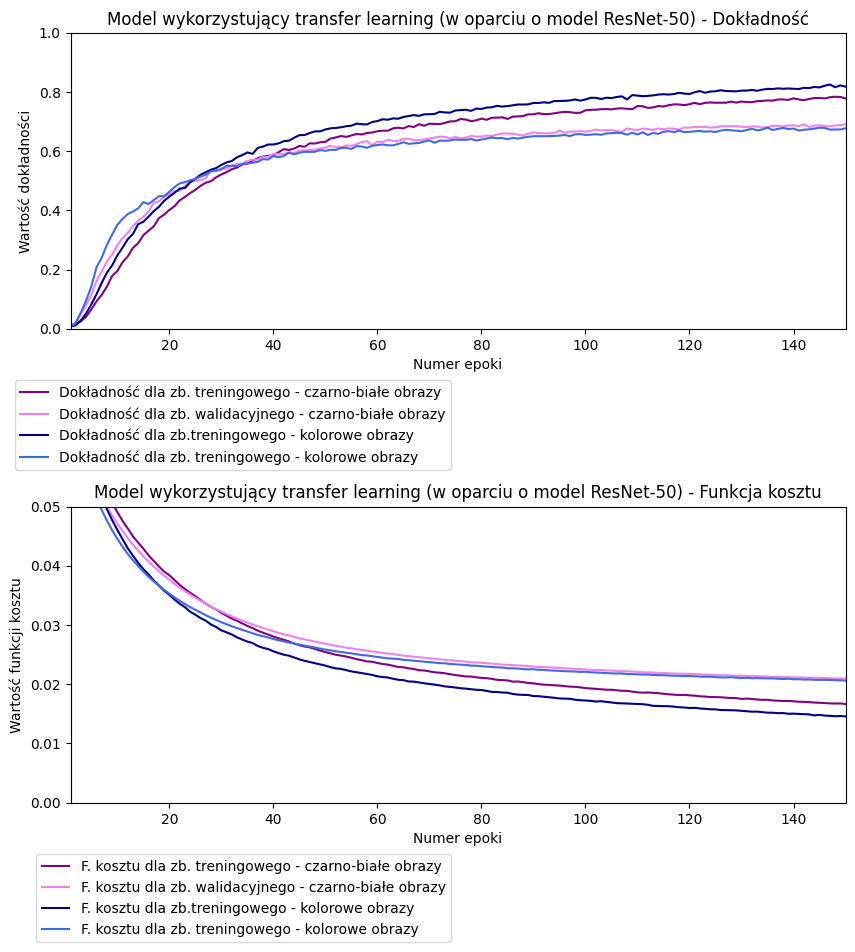

In [ ]:
plot_params(res_bw_3, res_c_3, 'Model wykorzystujący transfer learning (w oparciu o model ResNet-50)')

In [29]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False, input_shape=(100, 100, 3))
res_c_4 = run_model(get_transfer_based_model(d_col.labels_len, base_model), d_col)
res_bw_4 = run_model(get_transfer_based_model(d_bw_3.labels_len, base_model), d_bw_3)

Epoch 1/150
152/152 [==============================] - 22s 66ms/step - loss: 1.5413 - accuracy: 0.0104 - val_loss: 0.4066 - val_accuracy: 0.0088
Epoch 2/150
152/152 [==============================] - 10s 64ms/step - loss: 0.4714 - accuracy: 0.0110 - val_loss: 0.4016 - val_accuracy: 0.0139
Epoch 3/150
152/152 [==============================] - 10s 63ms/step - loss: 0.4613 - accuracy: 0.0126 - val_loss: 0.3935 - val_accuracy: 0.0175
Epoch 4/150
152/152 [==============================] - 10s 66ms/step - loss: 0.4494 - accuracy: 0.0118 - val_loss: 0.3845 - val_accuracy: 0.0299
Epoch 5/150
152/152 [==============================] - 9s 58ms/step - loss: 0.4393 - accuracy: 0.0114 - val_loss: 0.3755 - val_accuracy: 0.0247
Epoch 6/150
152/152 [==============================] - 9s 58ms/step - loss: 0.4291 - accuracy: 0.0168 - val_loss: 0.3712 - val_accuracy: 0.0361
Epoch 7/150
152/152 [==============================] - 10s 67ms/step - loss: 0.4209 - accuracy: 0.0145 - val_loss: 0.3588 - val_accu

In [30]:
dump_res(res_bw_4, res_c_4)

0.34072163701057434 [0.013917526230216026, 0.020618556067347527, 0.025773195549845695, 0.03144329786300659, 0.04536082595586777, 0.04536082595586777, 0.055670104920864105, 0.05309278517961502, 0.06443298608064651, 0.0757731944322586, 0.07113402336835861, 0.060824740678071976, 0.08298969268798828, 0.08865979313850403, 0.0958762913942337, 0.07731958478689194, 0.09329897165298462, 0.10876289010047913, 0.11701031029224396, 0.13969072699546814, 0.12422680109739304, 0.12628865242004395, 0.12164948135614395, 0.1407216489315033, 0.14639174938201904, 0.13350515067577362, 0.13247422873973846, 0.15257732570171356, 0.12783505022525787, 0.1721649467945099, 0.16030928492546082, 0.16340206563472748, 0.15309278666973114, 0.1649484485387802, 0.1494845300912857, 0.1809278279542923, 0.16804124414920807, 0.18865978717803955, 0.1515463888645172, 0.17525772750377655, 0.19226804375648499, 0.2185567021369934, 0.21082474291324615, 0.20206186175346375, 0.1989690661430359, 0.20824742317199707, 0.2314433008432388

In [ ]:
#0.34072163701057434 [0.013917526230216026, 0.020618556067347527, 0.025773195549845695, 0.03144329786300659, 0.04536082595586777, 0.04536082595586777, 0.055670104920864105, 0.05309278517961502, 0.06443298608064651, 0.0757731944322586, 0.07113402336835861, 0.060824740678071976, 0.08298969268798828, 0.08865979313850403, 0.0958762913942337, 0.07731958478689194, 0.09329897165298462, 0.10876289010047913, 0.11701031029224396, 0.13969072699546814, 0.12422680109739304, 0.12628865242004395, 0.12164948135614395, 0.1407216489315033, 0.14639174938201904, 0.13350515067577362, 0.13247422873973846, 0.15257732570171356, 0.12783505022525787, 0.1721649467945099, 0.16030928492546082, 0.16340206563472748, 0.15309278666973114, 0.1649484485387802, 0.1494845300912857, 0.1809278279542923, 0.16804124414920807, 0.18865978717803955, 0.1515463888645172, 0.17525772750377655, 0.19226804375648499, 0.2185567021369934, 0.21082474291324615, 0.20206186175346375, 0.1989690661430359, 0.20824742317199707, 0.23144330084323883, 0.21494846045970917, 0.21958762407302856, 0.1963917464017868, 0.21134020388126373, 0.21958762407302856, 0.22886598110198975, 0.22474226355552673, 0.23711340129375458, 0.20927834510803223, 0.22164948284626007, 0.24690721929073334, 0.24896907806396484, 0.2386597990989685, 0.272680401802063, 0.2567010223865509, 0.2654639184474945, 0.24020618200302124, 0.2654639184474945, 0.23762886226177216, 0.29123711585998535, 0.26855671405792236, 0.26443299651145935, 0.2793814539909363, 0.2701030969619751, 0.2963917553424835, 0.24690721929073334, 0.2829896807670593, 0.2762886583805084, 0.2773195803165436, 0.2907216548919678, 0.2659793794155121, 0.2943299114704132, 0.28247421979904175, 0.2948453724384308, 0.2788659930229187, 0.2994845509529114, 0.29381442070007324, 0.3128865957260132, 0.28659793734550476, 0.2927834987640381, 0.2762886583805084, 0.30927833914756775, 0.30721649527549744, 0.32061856985092163, 0.29845359921455383, 0.29329895973205566, 0.30721649527549744, 0.3278350532054901, 0.2943299114704132, 0.3211340308189392, 0.2835051417350769, 0.280927836894989, 0.2922680377960205, 0.3128865957260132, 0.30000001192092896, 0.2881443202495575, 0.31082475185394287, 0.30051547288894653, 0.2994845509529114, 0.3195876181125641, 0.32216495275497437, 0.3211340308189392, 0.3015463948249817, 0.28041237592697144, 0.3103092908859253, 0.29123711585998535, 0.32268041372299194, 0.29793813824653625, 0.2927834987640381, 0.30721649527549744, 0.2974226772785187, 0.3231958746910095, 0.2881443202495575, 0.32268041372299194, 0.31855669617652893, 0.3128865957260132, 0.3242267966270447, 0.30000001192092896, 0.2974226772785187, 0.3149484395980835, 0.32268041372299194, 0.3350515365600586, 0.2948453724384308, 0.31082475185394287, 0.3242267966270447, 0.3175257742404938, 0.3329896926879883, 0.3097938001155853, 0.311855673789978, 0.311855673789978, 0.32010307908058167, 0.32886597514152527, 0.30463916063308716, 0.3149484395980835, 0.34072163701057434, 0.33608248829841614, 0.303608238697052, 0.3170103132724762, 0.3149484395980835, 0.32474225759506226, 0.2943299114704132, 0.33402061462402344, 0.29123711585998535]
#0.29329895973205566 [0.010412370786070824, 0.011649484746158123, 0.014123711735010147, 0.01670103147625923, 0.0176288653165102, 0.018247421830892563, 0.019690722227096558, 0.022680412977933884, 0.022886598482728004, 0.024639174342155457, 0.02453608252108097, 0.026701031252741814, 0.025773195549845695, 0.028969071805477142, 0.02948453649878502, 0.030721649527549744, 0.03597938269376755, 0.036701031029224396, 0.03907216340303421, 0.0402061864733696, 0.039381444454193115, 0.04082474112510681, 0.04247422516345978, 0.04927834868431091, 0.04731958732008934, 0.04536082595586777, 0.05587628856301308, 0.05494845286011696, 0.05618556588888168, 0.05443298816680908, 0.06340206414461136, 0.061752576380968094, 0.06422680616378784, 0.06494845449924469, 0.07144329696893692, 0.07319587469100952, 0.07567010074853897, 0.07463917881250381, 0.07618556916713715, 0.08690721541643143, 0.08257731795310974, 0.08371134102344513, 0.09195876121520996, 0.08969072252511978, 0.10144329816102982, 0.09659793972969055, 0.10474226623773575, 0.09783504903316498, 0.10701031237840652, 0.11309278011322021, 0.10907216370105743, 0.11257731914520264, 0.11793814599514008, 0.12154639512300491, 0.12567010521888733, 0.12350515276193619, 0.128762885928154, 0.132886603474617, 0.140412375330925, 0.13773195445537567, 0.13649484515190125, 0.14257732033729553, 0.1453608274459839, 0.15164948999881744, 0.1582474261522293, 0.16360825300216675, 0.15855669975280762, 0.16216494143009186, 0.16979381442070007, 0.17237113416194916, 0.17855669558048248, 0.17608247697353363, 0.18463917076587677, 0.17855669558048248, 0.1879381388425827, 0.194020614027977, 0.20041237771511078, 0.19979381561279297, 0.19731958210468292, 0.20041237771511078, 0.20319586992263794, 0.21453608572483063, 0.20618556439876556, 0.2094845324754715, 0.2141237109899521, 0.21113401651382446, 0.22072164714336395, 0.22453607618808746, 0.22546391189098358, 0.2313401997089386, 0.22742268443107605, 0.2295876294374466, 0.2330927848815918, 0.23474226891994476, 0.24608246982097626, 0.24422679841518402, 0.24164947867393494, 0.23886598646640778, 0.2485567033290863, 0.24896907806396484, 0.24195876717567444, 0.24958762526512146, 0.2526804208755493, 0.2488659769296646, 0.2558763027191162, 0.25546392798423767, 0.2604123651981354, 0.25886598229408264, 0.2611340284347534, 0.2643299102783203, 0.2567010223865509, 0.2724742293357849, 0.2642267942428589, 0.2611340284347534, 0.26319587230682373, 0.2610309422016144, 0.25948452949523926, 0.26412370800971985, 0.2706185579299927, 0.27288660407066345, 0.2806185483932495, 0.2701030969619751, 0.27340206503868103, 0.2715463936328888, 0.27319586277008057, 0.2686598002910614, 0.27865979075431824, 0.2796907126903534, 0.28216496109962463, 0.269278347492218, 0.27814432978630066, 0.2790721654891968, 0.28690722584724426, 0.2811340093612671, 0.28835052251815796, 0.2911340296268463, 0.28020617365837097, 0.284432977437973, 0.2806185483932495, 0.28855669498443604, 0.28979381918907166, 0.2858762741088867, 0.2889690697193146, 0.291958749294281, 0.28340205550193787, 0.28103092312812805, 0.2896907329559326, 0.29092782735824585, 0.29329895973205566, 0.29123711585998535]
#0.03850219398736954 [0.3882473111152649, 0.37811359763145447, 0.3733757734298706, 0.35992586612701416, 0.34979870915412903, 0.33949795365333557, 0.3267075717449188, 0.3190462589263916, 0.31217700242996216, 0.29896119236946106, 0.29206207394599915, 0.28716954588890076, 0.2776988446712494, 0.26881518959999084, 0.2612924873828888, 0.2506698668003082, 0.24589139223098755, 0.23807592689990997, 0.2334272712469101, 0.22606372833251953, 0.2177114635705948, 0.2102472186088562, 0.20362572371959686, 0.20093493163585663, 0.19428905844688416, 0.18551695346832275, 0.18314889073371887, 0.1729782074689865, 0.1678897887468338, 0.16318058967590332, 0.15542598068714142, 0.15165908634662628, 0.1489953100681305, 0.1421021968126297, 0.13707830011844635, 0.1325341761112213, 0.12756560742855072, 0.11960828304290771, 0.11804487556219101, 0.11834392696619034, 0.10987590998411179, 0.10577058047056198, 0.10626598447561264, 0.09627822041511536, 0.09583669900894165, 0.09424276649951935, 0.09058770537376404, 0.08864952623844147, 0.08519870042800903, 0.08424197882413864, 0.07897331565618515, 0.07852786034345627, 0.07429219782352448, 0.07093682885169983, 0.07187516987323761, 0.06881668418645859, 0.06567481905221939, 0.0653853788971901, 0.06350035220384598, 0.06052856892347336, 0.061960238963365555, 0.05909547582268715, 0.059747252613306046, 0.057326920330524445, 0.05536406487226486, 0.05789822340011597, 0.05307485908269882, 0.054235488176345825, 0.05195791274309158, 0.05049062892794609, 0.05140424147248268, 0.04967015981674194, 0.05040496215224266, 0.04849228262901306, 0.049301858991384506, 0.04769233241677284, 0.046707652509212494, 0.04728357121348381, 0.045095667243003845, 0.04606913775205612, 0.04522591829299927, 0.04610192030668259, 0.04457613080739975, 0.04526599124073982, 0.0429302453994751, 0.045050594955682755, 0.043543361127376556, 0.044007446616888046, 0.04289335757493973, 0.04301920533180237, 0.041467342525720596, 0.04382927343249321, 0.04176018387079239, 0.04253343120217323, 0.04061860218644142, 0.04203740134835243, 0.04188062250614166, 0.04160686209797859, 0.042223844677209854, 0.042206376791000366, 0.04163309186697006, 0.04113563522696495, 0.043183617293834686, 0.04043452441692352, 0.041748326271772385, 0.04068717733025551, 0.040790949016809464, 0.04015946388244629, 0.04017828404903412, 0.04085184261202812, 0.0420561358332634, 0.04143877699971199, 0.04053749889135361, 0.04051187261939049, 0.040702320635318756, 0.04085901007056236, 0.04138894006609917, 0.040966760367155075, 0.04038998484611511, 0.040508683770895004, 0.04048576578497887, 0.04107203707098961, 0.04007236659526825, 0.04010423272848129, 0.04031011089682579, 0.04045845940709114, 0.03985774144530296, 0.040197934955358505, 0.03951221704483032, 0.040726643055677414, 0.040527500212192535, 0.03939363360404968, 0.03983905911445618, 0.03918273374438286, 0.03936256095767021, 0.039405327290296555, 0.03980749845504761, 0.04068052023649216, 0.0393679253757, 0.038959234952926636, 0.0395495668053627, 0.0398302897810936, 0.03850219398736954, 0.04010709375143051, 0.03956390544772148, 0.04037283733487129, 0.039435748010873795, 0.040162719786167145, 0.03939603269100189, 0.040372334420681]
#0.04037288576364517 [1.5737603902816772, 0.4453590214252472, 0.4320332705974579, 0.4175105094909668, 0.40592893958091736, 0.3962273597717285, 0.38477882742881775, 0.37507200241088867, 0.36479899287223816, 0.3580418527126312, 0.34855908155441284, 0.34060168266296387, 0.33262553811073303, 0.32448405027389526, 0.31192827224731445, 0.30253443121910095, 0.29522737860679626, 0.28603026270866394, 0.279500275850296, 0.27023255825042725, 0.26271823048591614, 0.2567804455757141, 0.2501662075519562, 0.23875750601291656, 0.23326840996742249, 0.2265821248292923, 0.21733582019805908, 0.21144214272499084, 0.20414315164089203, 0.19937404990196228, 0.1918642371892929, 0.18431657552719116, 0.17954657971858978, 0.173601433634758, 0.16718077659606934, 0.16247457265853882, 0.15634626150131226, 0.15274015069007874, 0.14805306494235992, 0.14209219813346863, 0.13683421909809113, 0.13340520858764648, 0.12777990102767944, 0.12497665733098984, 0.11781637370586395, 0.11665084213018417, 0.11141079664230347, 0.10959180444478989, 0.10588660836219788, 0.10193532705307007, 0.09931697696447372, 0.09556759893894196, 0.09276083111763, 0.0901421383023262, 0.08776035904884338, 0.08551175147294998, 0.08285589516162872, 0.08105645328760147, 0.07788967341184616, 0.07633832097053528, 0.07556556910276413, 0.07284152507781982, 0.07130938768386841, 0.0693335011601448, 0.06785213202238083, 0.06606221199035645, 0.06539953500032425, 0.06379345804452896, 0.06221313029527664, 0.06119493022561073, 0.06002604961395264, 0.05968223512172699, 0.05775143951177597, 0.05778288096189499, 0.0567692406475544, 0.05546458438038826, 0.054457131773233414, 0.05400076508522034, 0.05340715870261192, 0.05255502089858055, 0.0521414577960968, 0.0510176457464695, 0.05125132203102112, 0.05085869878530502, 0.05001664534211159, 0.04996353015303612, 0.049337562173604965, 0.048656683415174484, 0.04874781146645546, 0.04776831716299057, 0.047726716846227646, 0.047389883548021317, 0.04709034785628319, 0.047038886696100235, 0.04633564502000809, 0.046326037496328354, 0.04564279317855835, 0.045749232172966, 0.04508333280682564, 0.044722188264131546, 0.045415911823511124, 0.04438411071896553, 0.04440634325146675, 0.044672347605228424, 0.044024620205163956, 0.04403718560934067, 0.04325729236006737, 0.04324624314904213, 0.04355310648679733, 0.04314924404025078, 0.04347391054034233, 0.04286927729845047, 0.04304609075188637, 0.04307328909635544, 0.04253566265106201, 0.04325905442237854, 0.0428817979991436, 0.04249392822384834, 0.04255148395895958, 0.04252536594867706, 0.0421808660030365, 0.04228207468986511, 0.04180487245321274, 0.042073607444763184, 0.041621796786785126, 0.04204794764518738, 0.04180225729942322, 0.041515614837408066, 0.04119149595499039, 0.04205729439854622, 0.041646815836429596, 0.04147258400917053, 0.04117579758167267, 0.04123000428080559, 0.04123498871922493, 0.041344281286001205, 0.04125872254371643, 0.040755562484264374, 0.04114930331707001, 0.04086942598223686, 0.041021861135959625, 0.04087594524025917, 0.040656644850969315, 0.04059121385216713, 0.0409175381064415, 0.04088401049375534, 0.04083624482154846, 0.04037288576364517, 0.040522556751966476, 0.04078751429915428]
#0.1989690661430359 [0.008762886747717857, 0.013917526230216026, 0.017525773495435715, 0.02989690750837326, 0.02474226802587509, 0.036082472652196884, 0.025257732719182968, 0.032474227249622345, 0.035567011684179306, 0.030412370339035988, 0.040721651166677475, 0.030927835032343864, 0.0402061864733696, 0.04329897090792656, 0.0469072163105011, 0.06134020537137985, 0.04948453605175018, 0.051030926406383514, 0.054123710840940475, 0.06597938388586044, 0.05618556588888168, 0.06134020537137985, 0.060824740678071976, 0.054123710840940475, 0.06752577424049377, 0.06185567006468773, 0.0690721645951271, 0.08195876330137253, 0.05154639109969139, 0.07422680407762527, 0.06855670362710953, 0.07628866285085678, 0.07835051417350769, 0.08195876330137253, 0.08195876330137253, 0.07216494530439377, 0.09226804226636887, 0.08762886375188828, 0.07010309398174286, 0.0938144326210022, 0.09072165191173553, 0.0804123729467392, 0.08608247339725494, 0.09484536200761795, 0.0938144326210022, 0.09329897165298462, 0.09226804226636887, 0.09020618349313736, 0.1005154624581337, 0.10824742168188095, 0.11288660019636154, 0.08865979313850403, 0.10103093087673187, 0.09432989358901978, 0.10773196071386337, 0.11649484187364578, 0.10309278219938278, 0.11649484187364578, 0.11907216161489487, 0.1025773212313652, 0.13659793138504028, 0.1340206116437912, 0.13092783093452454, 0.13298968970775604, 0.11855670064687729, 0.12886597216129303, 0.11958763003349304, 0.13144329190254211, 0.09742268174886703, 0.1582474261522293, 0.13556700944900513, 0.1206185594201088, 0.11752577126026154, 0.15257732570171356, 0.13917525112628937, 0.13453608751296997, 0.11494845151901245, 0.15927834808826447, 0.1453608274459839, 0.1319587677717209, 0.1716494858264923, 0.15670102834701538, 0.15721648931503296, 0.17938144505023956, 0.1608247458934784, 0.1453608274459839, 0.14020618796348572, 0.16443298757076263, 0.15670102834701538, 0.17474226653575897, 0.17319588363170624, 0.16185566782951355, 0.14845360815525055, 0.16443298757076263, 0.18144330382347107, 0.15515464544296265, 0.1541237086057663, 0.14175257086753845, 0.16649484634399414, 0.16804124414920807, 0.15257732570171356, 0.16134020686149597, 0.16030928492546082, 0.16597938537597656, 0.18195876479148865, 0.18402062356472015, 0.1628866046667099, 0.1582474261522293, 0.1587628871202469, 0.18144330382347107, 0.18247422575950623, 0.17577318847179413, 0.16030928492546082, 0.18144330382347107, 0.18041236698627472, 0.1649484485387802, 0.16907216608524323, 0.16804124414920807, 0.18247422575950623, 0.17525772750377655, 0.17474226653575897, 0.1850515455007553, 0.1587628871202469, 0.1520618498325348, 0.17474226653575897, 0.17783504724502563, 0.15773196518421173, 0.18917526304721832, 0.1762886643409729, 0.1896907240152359, 0.1675257682800293, 0.1520618498325348, 0.15567010641098022, 0.17731958627700806, 0.1649484485387802, 0.1608247458934784, 0.18814432621002197, 0.18041236698627472, 0.1989690661430359, 0.16546392440795898, 0.1917525827884674, 0.17319588363170624, 0.15567010641098022, 0.17319588363170624, 0.18144330382347107, 0.17680412530899048, 0.16701030731201172, 0.17113402485847473, 0.1721649467945099, 0.17989690601825714]
#0.16587628424167633 [0.010412370786070824, 0.01103092823177576, 0.012577319517731667, 0.011752577498555183, 0.011443299241364002, 0.016804123297333717, 0.014536082744598389, 0.012577319517731667, 0.01505154650658369, 0.014639175496995449, 0.019484536722302437, 0.018350515514612198, 0.01742267981171608, 0.017525773495435715, 0.018350515514612198, 0.017525773495435715, 0.021030927076935768, 0.021340206265449524, 0.0201030932366848, 0.022886598482728004, 0.025154639035463333, 0.024226803332567215, 0.023402061313390732, 0.02814432978630066, 0.025567010045051575, 0.02701030857861042, 0.02608247473835945, 0.030515464022755623, 0.03154639154672623, 0.029793813824653625, 0.0320618562400341, 0.03123711422085762, 0.03278350457549095, 0.03587628901004791, 0.03288659825921059, 0.03597938269376755, 0.03752577304840088, 0.038969073444604874, 0.041649483144283295, 0.04381443187594414, 0.039381444454193115, 0.0469072163105011, 0.04113402217626572, 0.04597938060760498, 0.043608248233795166, 0.05268041417002678, 0.05092783644795418, 0.05072164908051491, 0.055670104920864105, 0.05381443351507187, 0.055463917553424835, 0.058350514620542526, 0.05577319487929344, 0.06268041580915451, 0.06268041580915451, 0.06309278309345245, 0.06391752511262894, 0.06577319651842117, 0.06979381293058395, 0.07000000029802322, 0.07329896837472916, 0.07257732003927231, 0.08371134102344513, 0.08134020864963531, 0.08082474023103714, 0.08649484813213348, 0.08577319234609604, 0.08577319234609604, 0.08907216787338257, 0.08979381620883942, 0.09226804226636887, 0.09505154937505722, 0.08876288682222366, 0.09845361113548279, 0.09505154937505722, 0.09659793972969055, 0.1005154624581337, 0.09989690780639648, 0.10206185281276703, 0.1040206179022789, 0.10587628930807114, 0.11329896748065948, 0.11371134221553802, 0.10680412501096725, 0.11711340397596359, 0.11855670064687729, 0.11711340397596359, 0.12154639512300491, 0.11793814599514008, 0.12206185609102249, 0.12298969179391861, 0.12680412828922272, 0.12226804345846176, 0.12226804345846176, 0.1258762925863266, 0.12845361232757568, 0.13092783093452454, 0.13278350234031677, 0.1308247447013855, 0.1279381513595581, 0.1392783522605896, 0.13907216489315033, 0.13474227488040924, 0.13556700944900513, 0.1354639232158661, 0.1407216489315033, 0.14556701481342316, 0.14082473516464233, 0.14288659393787384, 0.14690721035003662, 0.14195875823497772, 0.14340205490589142, 0.13742268085479736, 0.14381442964076996, 0.14494845271110535, 0.14969071745872498, 0.14762885868549347, 0.15195876359939575, 0.1506185531616211, 0.1520618498325348, 0.15556700527668, 0.15639175474643707, 0.15546391904354095, 0.14814433455467224, 0.15103092789649963, 0.1599999964237213, 0.15319587290287018, 0.15309278666973114, 0.16061855852603912, 0.15144330263137817, 0.15484535694122314, 0.15216495096683502, 0.15515464544296265, 0.15845361351966858, 0.15855669975280762, 0.15979380905628204, 0.16587628424167633, 0.15783505141735077, 0.1573195904493332, 0.1547422707080841, 0.15948453545570374, 0.15752577781677246, 0.15505154430866241, 0.16484536230564117, 0.16041237115859985, 0.1640206128358841, 0.16525773704051971, 0.16536082327365875, 0.16350515186786652, 0.16247422993183136]
#0.04719318076968193 [0.40656575560569763, 0.4015522003173828, 0.3935185670852661, 0.38452187180519104, 0.3754770755767822, 0.3712042570114136, 0.35877734422683716, 0.35332751274108887, 0.3458544909954071, 0.3390319049358368, 0.3279036283493042, 0.32171013951301575, 0.3105021119117737, 0.3076179623603821, 0.29963943362236023, 0.28929945826530457, 0.2857917249202728, 0.2798323929309845, 0.27088919281959534, 0.260590523481369, 0.25447624921798706, 0.24573591351509094, 0.24130016565322876, 0.23699454963207245, 0.22622092068195343, 0.2198682576417923, 0.21277233958244324, 0.20482587814331055, 0.20177032053470612, 0.19234395027160645, 0.18549440801143646, 0.18096435070037842, 0.17264245450496674, 0.1681273728609085, 0.1642654985189438, 0.157390296459198, 0.15464363992214203, 0.14955440163612366, 0.1420690268278122, 0.1363781988620758, 0.13334351778030396, 0.12696723639965057, 0.12371396273374557, 0.12088299542665482, 0.11681187897920609, 0.11055666953325272, 0.11022130399942398, 0.10541266202926636, 0.10049392282962799, 0.0998782068490982, 0.09448108822107315, 0.0945085734128952, 0.09113482385873795, 0.08699709922075272, 0.08422140777111053, 0.08212487399578094, 0.07860799133777618, 0.07776018977165222, 0.07638361304998398, 0.07606999576091766, 0.0696975514292717, 0.06931805610656738, 0.0687476173043251, 0.06808174401521683, 0.0653446689248085, 0.06570690125226974, 0.06295142322778702, 0.06331747770309448, 0.06232926622033119, 0.05944927781820297, 0.05849830433726311, 0.06021914258599281, 0.05832434818148613, 0.0566624291241169, 0.0571565143764019, 0.05599472299218178, 0.054595496505498886, 0.05404217541217804, 0.054160572588443756, 0.05562228336930275, 0.053601864725351334, 0.05300000682473183, 0.052625399082899094, 0.05245423689484596, 0.05188148468732834, 0.052854765206575394, 0.052460927516222, 0.05055024474859238, 0.051329296082258224, 0.05037602782249451, 0.049737781286239624, 0.05068623274564743, 0.050872523337602615, 0.05116444081068039, 0.04950827732682228, 0.050516463816165924, 0.04959051311016083, 0.05141693726181984, 0.05031423270702362, 0.050019510090351105, 0.05075422674417496, 0.050260238349437714, 0.0485256128013134, 0.05016807094216347, 0.04897358641028404, 0.048744358122348785, 0.05031391978263855, 0.050179965794086456, 0.05014608055353165, 0.04934987425804138, 0.04893077537417412, 0.04886550083756447, 0.048384301364421844, 0.04797687381505966, 0.0493839792907238, 0.04977184906601906, 0.04929840564727783, 0.04819933697581291, 0.0478658564388752, 0.04822607710957527, 0.04786890745162964, 0.04876247048377991, 0.04935611039400101, 0.048928454518318176, 0.048094492405653, 0.04907519370317459, 0.04949089512228966, 0.04719318076968193, 0.04928594455122948, 0.0482342503964901, 0.049084052443504333, 0.0493839867413044, 0.04844582453370094, 0.049088962376117706, 0.04810507223010063, 0.04979466646909714, 0.04908004030585289, 0.048421915620565414, 0.04816614091396332, 0.047903116792440414, 0.04780789092183113, 0.04823913797736168, 0.04989999905228615, 0.048189349472522736, 0.048250701278448105, 0.048511333763599396, 0.04821956157684326, 0.048288196325302124, 0.04842550307512283, 0.04750579223036766]
#0.04830680787563324 [1.5412882566452026, 0.4714178740978241, 0.4613186717033386, 0.4493756592273712, 0.4392596185207367, 0.42910024523735046, 0.42090484499931335, 0.41300341486930847, 0.40503209829330444, 0.39297550916671753, 0.3855453431606293, 0.37644416093826294, 0.3660834729671478, 0.3584756553173065, 0.350521981716156, 0.3402371406555176, 0.3355408012866974, 0.3264508545398712, 0.3144899904727936, 0.30617785453796387, 0.2995082437992096, 0.2913639545440674, 0.28330519795417786, 0.2753903567790985, 0.2661196291446686, 0.25904056429862976, 0.2514336407184601, 0.24090847373008728, 0.23662403225898743, 0.22806298732757568, 0.2214621752500534, 0.2139488309621811, 0.20716939866542816, 0.20026981830596924, 0.1926112025976181, 0.18660256266593933, 0.18057884275913239, 0.17503952980041504, 0.1685076355934143, 0.16330283880233765, 0.15730266273021698, 0.15232154726982117, 0.148175910115242, 0.1431976556777954, 0.1383870542049408, 0.1331237107515335, 0.12863849103450775, 0.12484828382730484, 0.12106624990701675, 0.11703675240278244, 0.11426711082458496, 0.10833042114973068, 0.10711769014596939, 0.10244549065828323, 0.10068994760513306, 0.09662935882806778, 0.09378964453935623, 0.09138103574514389, 0.08862665295600891, 0.08617623150348663, 0.08405257761478424, 0.08165613561868668, 0.07988165318965912, 0.07890157401561737, 0.0763896033167839, 0.07459991425275803, 0.07391822338104248, 0.07208314538002014, 0.07076384872198105, 0.06914729624986649, 0.06774856895208359, 0.06648315489292145, 0.06581427901983261, 0.06432869285345078, 0.06432163715362549, 0.06306473910808563, 0.0624859556555748, 0.06132059171795845, 0.06037839129567146, 0.05987992882728577, 0.0592542439699173, 0.05883881077170372, 0.057824600487947464, 0.057356465607881546, 0.05621856823563576, 0.05643204227089882, 0.05666651949286461, 0.05543352663516998, 0.055583104491233826, 0.055254027247428894, 0.05533581227064133, 0.05456048995256424, 0.05410712584853172, 0.05392974615097046, 0.054005593061447144, 0.053525686264038086, 0.052655402570962906, 0.05302334204316139, 0.05292202904820442, 0.05281838774681091, 0.05231596156954765, 0.05196351185441017, 0.05223942548036575, 0.05172594636678696, 0.051568612456321716, 0.0512772798538208, 0.05110374838113785, 0.05096562206745148, 0.05104311183094978, 0.05087142065167427, 0.0509130135178566, 0.05094333365559578, 0.050828661769628525, 0.0505497083067894, 0.050555188208818436, 0.0502658411860466, 0.050228383392095566, 0.05006124824285507, 0.05022542551159859, 0.04977445676922798, 0.04984796419739723, 0.04945458099246025, 0.04995877668261528, 0.049920618534088135, 0.049523141235113144, 0.04956185445189476, 0.04952459782361984, 0.049265775829553604, 0.04893163591623306, 0.04943675547838211, 0.049523547291755676, 0.04935484379529953, 0.049546465277671814, 0.04921039193868637, 0.049021974205970764, 0.048705101013183594, 0.04884837940335274, 0.04862016439437866, 0.04852757230401039, 0.04874993488192558, 0.0489514097571373, 0.04904559627175331, 0.04870878905057907, 0.04879067838191986, 0.04876982793211937, 0.04844079539179802, 0.04850837588310242, 0.04860281944274902, 0.04830680787563324, 0.04884455353021622]

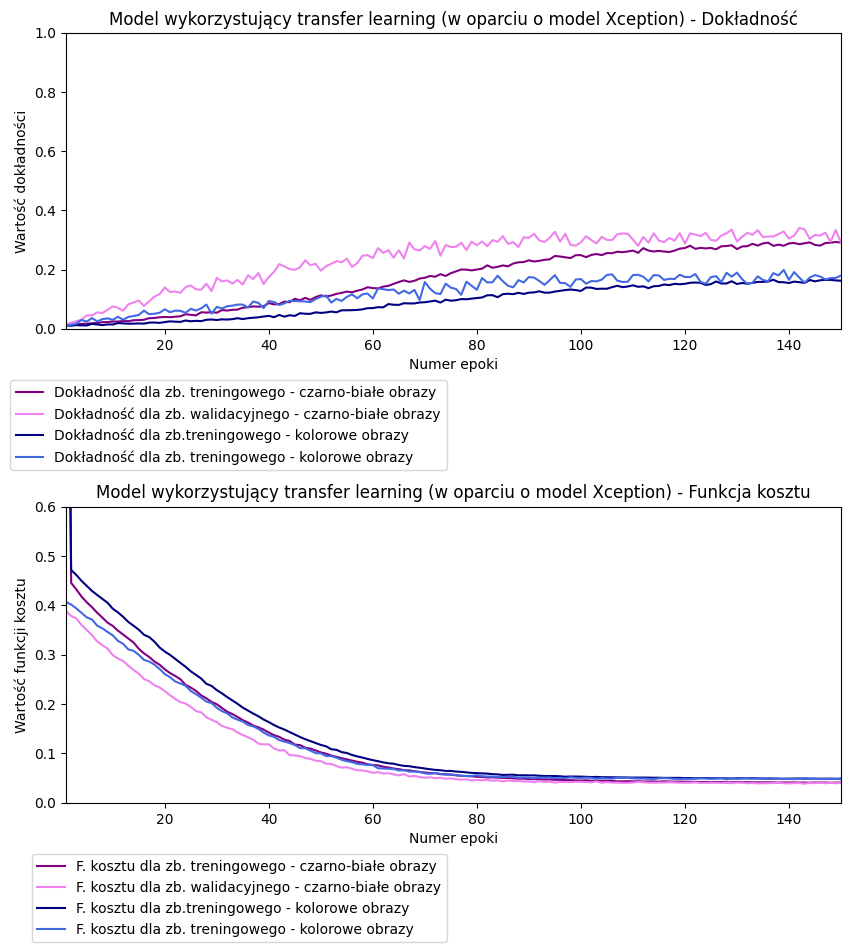

In [31]:
plot_params(res_bw_4, res_c_4, 'Model wykorzystujący transfer learning (w oparciu o model Xception)')